# Library design for CTP-03, Chr21_small

by Pu Zheng and Jun-Han Su

This library design is for human chr21

In [1]:
#minimum imports:
import time,os,sys,glob
import cPickle as pickle
import numpy as np
import khmer
sys.path.append(r'/n/home13/pzheng/Documents/python-functions/python-functions-library')

from LibraryConstruction import fastaread,fastawrite,fastacombine
import LibraryDesigner as ld
import LibraryConstruction as lc

## 1 Extract region sequences

In [2]:
## Some folders
# human genome
master_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng'
genome_folder = master_dir + os.sep + r'Genomes/human/hg38/chroms';

### 1.1 Chr21

In [8]:
def Batch_Extract_Sequences(reg_dir, reg_filename =r'Regions.txt', \
                            genome_dir=r'Genomes/human/hg38/chroms',\
                            save_dir=r'region_seqs',\
                            master_dir=r'/n/boslfs/LABS/zhuang_lab/User/pzheng',\
                            merge=True, save=True, resolution=10000, flanking=100000):
    '''Function to extract sequences for all regions written in a file
    Given:
    
    merge: if merge all regions together and arrange region id, bool'''
    genome_folder = master_dir + os.sep + genome_dir; # get genome folder full path
    region_folder = master_dir + os.sep + reg_dir;
    save_folder = region_folder + os.sep + save_dir;
    if not isinstance(region_folder, str) and not isinstance(reg_filename, str) \
        and not isinstance(genome_folder, str):
        raise ValueError('wrong input format!');

    def read_region_file(region_folder=region_folder, reg_filename=reg_filename):
        '''Sub-function to read region file'''
        # region filename
        _reg_filename = region_folder + os.sep + reg_filename;
        _reg_file = open(_reg_filename, 'r');    
        print 'Input region file is: '+ _reg_filename;
        # start reading
        _lines = _reg_file.read().split('\n')
        _titles = _lines[0].split('\t');
        # save a list of dictionaries
        _reg_list = [];
        for _line in _lines[1:]:
            _reg_dic = {}; # dinctionary to save all informations
            _info = _line.split('\t'); # split informations
            if len(_info) != len(_titles): # sanity check to make sure they are of the same size
                continue;
            for _i in range(len(_info)): # save info to dic
                _reg_dic[_titles[_i]] = _info[_i];
            _reg_list.append(_reg_dic); # save dic to list
        _reg_file.close();
        return _reg_list

    def parse_region(reg_dic):
        '''given a dictionary of one region, 
        report:
            _chrom: str
            _start: int
            _stop: int'''
        region_str = reg_dic['Region'];
        # grab chromosome
        _chrom = region_str.split(':')[0];
        _locus = region_str.split(':')[1];
        # grab start and stop positions
        _start, _stop = _locus.split('-')
        _start = int(_start.replace(',', ''));
        _stop = int(_stop.replace(',', ''));
        # return in this order:
        return _chrom, _start, _stop
    
    def extract_sequence(reg_dic, genome_folder=genome_folder, \
                         resolution=resolution, flanking=flanking, \
                         save_folder=save_folder, save=save, merge=merge):
        from math import ceil
        '''sub-function to extract sequences of one locus
        Given:
        reg_dic: dic for region info, dictionary
        genome_folder: dir for genome files, str
        resolution: resolution of each region in bp, int
        flanking: upstream and downstream included in bp, int
        save: if save as fasta files, bool
        Return:
        dic of sequences of designed regions
        Dependencies:
        ld.fastaread, ld.fastawrite, ./parse_region'''
        # get chromosome, start and stop information
        _chrom, _start, _stop = parse_region(reg_dic);
        # dir to store sequences, this will be returned
        _seq_dic = {};
        _seqs = []
        _names = []
        if not flanking:
            flanking=0;
        # read chromosome seq
        _, _wholechr = ld.fastaread(genome_folder+os.sep+_chrom+'.fa')
        _wholechr = _wholechr[0];
        # number of regions
        _n_reg = int(ceil( float(_stop+flanking - (_start-flanking)) / resolution))
        # extract all required seq
        _whole_seq = _wholechr[_start-flanking: min(_start-flanking+_n_reg*resolution, len(_wholechr))];
        for _i in range(_n_reg):
            # extract sequence for this region
            if len(_whole_seq) < (_i+1)*resolution:
                break;
            _seq = _whole_seq[_i*resolution:(_i+1)*resolution];
            _name = _chrom+':'+str(_start-flanking+_i*resolution)+'-'+\
                     str(_start-flanking+(_i+1)*resolution)+'_reg_'+str(_i+1);
            _seq_dic[_name] = _seq;
            _seqs.append(_seq);
            _names.append(_name);
        # if Save
        if save:                
            # mkdir if not exist for save folder
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
                
            print '-writing region number:' + str(_n_reg);
            
            if merge: # NOTICE! this will never overwrite!
                save_sub_folder = save_folder+os.sep+'merged';
                if not os.path.exists(save_sub_folder):
                    os.makedirs(save_sub_folder)
                ex_file_num = len(glob.glob(save_sub_folder+os.sep+r'*'));
                # writing files
                for _i in range(_n_reg):
                    _filename = save_sub_folder + os.sep + 'reg_' + str(ex_file_num+_i+1) + '.fasta';
                    # save as fasta
                    if 'Gene' in reg_dic.keys():
                        ld.fastawrite(_filename, [_names[_i]+'_gene_'+reg_dic['Gene']], [_seqs[_i].upper()])
                    else:
                        ld.fastawrite(_filename, [_names[_i]], [_seqs[_i].upper()])
                print 'Number of region: '+str(len(glob.glob(save_sub_folder+os.sep+r'*')));
            else:
                # assign correct name of the sub folder
                if 'Gene' in reg_dic.keys():
                    save_sub_folder = save_folder+os.sep+reg_dic['Gene'];
                else:
                    save_sub_folder = save_folder+os.sep+_chrom+str(_start);
                # mkdir if not exist for this region
                if not os.path.exists(save_sub_folder):
                    os.makedirs(save_sub_folder)
                # writing files
                for _i in range(_n_reg):
                    _filename = save_sub_folder + os.sep + 'reg_' + str(_i+1) + '.fasta';
                    # save as fasta
                    ld.fastawrite(_filename, [_names[_i]], [_seqs[_i].upper()])
                
        return _seq_dic
        
    ## read region file
    reg_list = read_region_file();
    
    # extract sequences and save!
    seq_dic_list = [];
    for reg_dic in reg_list:
        seqs = extract_sequence(reg_dic, save=True)
        seq_dic_list.append(seqs);
        
    return seq_dic_list, reg_list
        

## 1.2 write information for parsing whole chromosome 21 

In [7]:
## write a region file
# environment
master_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng';
region_dir = r'Libraries/SI-14/chr21';
region_folder = master_dir + os.sep + region_dir;
reg_filename =r'Regions.txt'
res = 50000 # 50kb resolution
# make dir if not exist
if not os.path.exists(region_folder):
    os.makedirs(region_folder)
# information which is going to be writted into region file
region_titles = ['Gene', 'Region', 'Strand'];
region_infos = ['chr21', 'chr21:1-46709983', '+'];
# writing information!
with open(region_folder+os.sep+reg_filename, 'w') as region_handle:
    for title in region_titles:
        region_handle.write(title+'\t');
    region_handle.write('\n');
    for info in region_infos:
        region_handle.write(info+'\t');    

## 1.3 start parsing chr21!

In [ ]:
## Split the sequence!
seq_dic_list, reg_list = Batch_Extract_Sequences(reg_dir=region_dir,
                                                 reg_filename = reg_filename,
                                                 master_dir=master_dir,
                                                 resolution=res, flanking=0,
                                                 merge=True, save=True)

# 2 Design Probes

In [2]:
##Construct SI15 probes-whole_chr21
import time,os,sys
reload(ld)
import matplotlib.pyplot as plt
plt.switch_backend('agg')

# Indeces
index_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Indeces/human/hg38';
genmoe_index = index_folder + os.sep + r'full_word17_.kmer';
repeat_index = index_folder + os.sep + r'HumanRepeats_word17_.kmer';
transcriptome_index = index_folder + os.sep + r'transcriptome_word17_.kmer';
# Used directories
master_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng';
region_dir = r'Libraries/SI-14/chr21';
region_folder = master_dir + os.sep + region_dir;
seq_dir = r'/region_seqs/merged'; # if merged previously
save_dir = r'/reports/merged'; # if merged
# get input and output 
input_files = glob.glob(region_folder+seq_dir+os.sep+r'*.fasta')
save_folder = region_folder + save_dir;

if not os.path.exists(save_folder):
    os.makedirs(save_folder);
# Loop through all input files
for in_file in input_files:
    #print in_file
    save_file = save_folder+os.sep+os.path.basename(in_file).replace('.fasta','.pbr')#'/pb_reports_reg_'+str(-i-1)+'.pbr'
    if not os.path.exists(save_file): # if probe report file doesnt exist
        
        local_genome_fl = in_file
        print in_file;
        pb_designer = ld.pb_reports_class(
            sequence_dic={'file':in_file,'use_revc':False,'use_kmer':True},
            map_dic={'genome':{'file':genmoe_index,'use_revc':True,'use_kmer':True},
                  'rep_genome':{'file':repeat_index,'use_revc':True,'use_kmer':True},
                  'local_genome':{'file':local_genome_fl,'force_list':True,'use_revc':True,'use_kmer':True}},
            save_file=save_file,
            params_dic={'word_size':17,'pb_len':42,'buffer_len':2,'max_count':2**16-1,'check_on_go':False,'auto':False},
            dic_check={('genome','local_genome'):75,'rep_genome':0,'gc':[0.25,0.85],'tm':70,'masks':['AAAAA','TTTTT','GGGGG','CCCCC']})

        pb_designer.computeOTmaps()
        pb_designer.compute_pb_report()
        pb_designer.perform_check_end()
        pb_designer.plots()
        print len(pb_designer.pb_reports_keep)

/n/home13/pzheng/.conda/envs/python27rc2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_679.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.389878035
Dealing with sequence: 1 out of 1
Time(s): 18.3869318962
Picking non-overlaping sequences.
Time(s): 2.52659511566
524
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_590.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.461247921
Dealing with sequence: 1 out of 1
Time(s): 18.6344828606
Picking non-overlaping sequences.
Time(s): 2.46805787086
679
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_513.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.257029057
Dealing with sequence: 1 out of 1
Time(s): 18.5

Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.251125813
Dealing with sequence: 1 out of 1
Time(s): 15.6100459099
Picking non-overlaping sequences.
Time(s): 0.013170003891
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_226.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.976577044
Dealing with sequence: 1 out of 1
Time(s): 18.7740101814
Picking non-overlaping sequences.
Time(s): 1.60553383827
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_813.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 141.158977985
Dealing with sequence: 1 out of 1
Time(s): 18.5131649971
Picking non-overlaping sequences.
Time(s): 2.38251304626
698
/n/boslfs/LABS/zhuang_lab

Setting attribute: map_rep_genome
Time(s): 136.250996113
Dealing with sequence: 1 out of 1
Time(s): 16.8290851116
Picking non-overlaping sequences.
Time(s): 0.416394948959
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_803.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.252839804
Dealing with sequence: 1 out of 1
Time(s): 18.7607409954
Picking non-overlaping sequences.
Time(s): 2.6052339077
593
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_303.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.259049892
Dealing with sequence: 1 out of 1
Time(s): 18.5523929596
Picking non-overlaping sequences.
Time(s): 2.37525200844
695
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_435.fasta
Setting attribute: m

Setting attribute: map_rep_genome
Time(s): 136.251792908
Dealing with sequence: 1 out of 1
Time(s): 18.2661659718
Picking non-overlaping sequences.
Time(s): 2.27699112892
704
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_24.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.263243914
Dealing with sequence: 1 out of 1
Time(s): 15.8017010689
Picking non-overlaping sequences.
Time(s): 0.0131690502167
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_150.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.316344976
Dealing with sequence: 1 out of 1
Time(s): 18.4984810352
Picking non-overlaping sequences.
Time(s): 3.37110590935
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_215.fasta
Setting attribute: ma

Setting attribute: map_rep_genome
Time(s): 136.251834154
Dealing with sequence: 1 out of 1
Time(s): 18.5849328041
Picking non-overlaping sequences.
Time(s): 2.50193881989
565
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_42.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.245271921
Dealing with sequence: 1 out of 1
Time(s): 15.6329967976
Picking non-overlaping sequences.
Time(s): 0.0129749774933
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_75.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.304481983
Dealing with sequence: 1 out of 1
Time(s): 15.6900758743
Picking non-overlaping sequences.
Time(s): 0.0126581192017
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_871.fasta
Setting attribute: m

Setting attribute: map_rep_genome
Time(s): 136.258798122
Dealing with sequence: 1 out of 1
Time(s): 18.8115999699
Picking non-overlaping sequences.
Time(s): 2.44052910805
616
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_227.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.256703138
Dealing with sequence: 1 out of 1
Time(s): 18.5029242039
Picking non-overlaping sequences.
Time(s): 1.48623013496
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_735.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.285773993
Dealing with sequence: 1 out of 1
Time(s): 18.5215129852
Picking non-overlaping sequences.
Time(s): 2.3018488884
792
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_169.fasta
Setting attribute: ma

In [2]:
prob_lens = [];


# Used directories
master_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng';
region_dir = r'Libraries/SI-14/chr21';
region_folder = master_dir + os.sep + region_dir;
save_dir = r'/reports/merged'; # if merged
# get previous outputs
save_folder = region_folder + save_dir;

#to continue or check sequences:
reload(ld)

pbde = ld.pb_reports_class()
files = glob.glob(save_folder+os.sep+r'*.pbr')
for file_ in files:
    pbde.load_pbr(file_)
    pbde.dic_check={'gc': [0.25, 0.85], 'rep_genome': 0, 'tm': 70, ('genome', 'local_genome'): 75,
                    'masks':['AAAAA','TTTTT','GGGGG','CCCCC']}
    pbde.perform_check_end()
    print file_
    print len(pbde.pb_reports_keep)
    prob_lens.append(len(pbde.pb_reports_keep))
    pbde.save_csv()
    #pbde.plots()

Picking non-overlaping sequences.
Time(s): 2.81264591217
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_343.pbr
435
Picking non-overlaping sequences.
Time(s): 2.92764377594
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_924.pbr
340
Picking non-overlaping sequences.
Time(s): 1.19924783707
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_253.pbr
0
Picking non-overlaping sequences.
Time(s): 1.61854696274
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_225.pbr
0
Picking non-overlaping sequences.
Time(s): 2.45497322083
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_703.pbr
672
Picking non-overlaping sequences.
Time(s): 2.78777194023
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_788.pbr
440
Picking non-overlaping sequences.
Time(s): 3.54409003258
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21

Picking non-overlaping sequences.
Time(s): 2.59776306152
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_752.pbr
578
Picking non-overlaping sequences.
Time(s): 2.38039398193
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_105.pbr
53
Picking non-overlaping sequences.
Time(s): 1.5715110302
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_235.pbr
0
Picking non-overlaping sequences.
Time(s): 2.38502788544
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_901.pbr
717
Picking non-overlaping sequences.
Time(s): 3.14430093765
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_266.pbr
221
Picking non-overlaping sequences.
Time(s): 2.10056591034
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_852.pbr
786
Picking non-overlaping sequences.
Time(s): 2.7023088932
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/

Picking non-overlaping sequences.
Time(s): 2.49071311951
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_730.pbr
666
Picking non-overlaping sequences.
Time(s): 2.49348402023
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_508.pbr
587
Picking non-overlaping sequences.
Time(s): 3.70148181915
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_137.pbr
7
Picking non-overlaping sequences.
Time(s): 2.20871591568
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_898.pbr
818
Picking non-overlaping sequences.
Time(s): 2.27172398567
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_302.pbr
769
Picking non-overlaping sequences.
Time(s): 2.6751999855
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_509.pbr
466
Picking non-overlaping sequences.
Time(s): 0.0231142044067
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/ch

Picking non-overlaping sequences.
Time(s): 2.62930893898
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_352.pbr
528
Picking non-overlaping sequences.
Time(s): 2.46579504013
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_627.pbr
628
Picking non-overlaping sequences.
Time(s): 1.62205505371
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_224.pbr
0
Picking non-overlaping sequences.
Time(s): 2.62391996384
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_456.pbr
503
Picking non-overlaping sequences.
Time(s): 0.0343029499054
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_61.pbr
0
Picking non-overlaping sequences.
Time(s): 2.47881197929
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_684.pbr
642
Picking non-overlaping sequences.
Time(s): 1.6695599556
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21

Picking non-overlaping sequences.
Time(s): 3.04843902588
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_561.pbr
255
Picking non-overlaping sequences.
Time(s): 2.67259192467
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_376.pbr
488
Picking non-overlaping sequences.
Time(s): 2.61385893822
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_403.pbr
487
Picking non-overlaping sequences.
Time(s): 2.51466679573
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_873.pbr
503
Picking non-overlaping sequences.
Time(s): 1.61630511284
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_228.pbr
0
Picking non-overlaping sequences.
Time(s): 2.54260802269
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_566.pbr
614
Picking non-overlaping sequences.
Time(s): 2.28124189377
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr

Picking non-overlaping sequences.
Time(s): 2.71261382103
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_572.pbr
461
Picking non-overlaping sequences.
Time(s): 2.55418920517
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_725.pbr
567
Picking non-overlaping sequences.
Time(s): 2.54547286034
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_442.pbr
515
Picking non-overlaping sequences.
Time(s): 0.0225172042847
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_25.pbr
0
Picking non-overlaping sequences.
Time(s): 3.05379199982
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_211.pbr
239
Picking non-overlaping sequences.
Time(s): 2.55560398102
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_666.pbr
592
Picking non-overlaping sequences.
Time(s): 3.44544196129
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/ch

Picking non-overlaping sequences.
Time(s): 2.70749902725
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_651.pbr
502
Picking non-overlaping sequences.
Time(s): 2.51432800293
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_886.pbr
589
Picking non-overlaping sequences.
Time(s): 3.3190369606
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_216.pbr
36
Picking non-overlaping sequences.
Time(s): 0.32174706459
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_206.pbr
7
Picking non-overlaping sequences.
Time(s): 0.0403280258179
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_16.pbr
0
Picking non-overlaping sequences.
Time(s): 2.3236579895
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_777.pbr
727
Picking non-overlaping sequences.
Time(s): 2.63854002953
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/r

Picking non-overlaping sequences.
Time(s): 2.32104492188
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_618.pbr
657
Picking non-overlaping sequences.
Time(s): 3.42059493065
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_273.pbr
15
Picking non-overlaping sequences.
Time(s): 2.69946599007
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_733.pbr
614
Picking non-overlaping sequences.
Time(s): 0.0226249694824
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_14.pbr
0
Picking non-overlaping sequences.
Time(s): 2.67073392868
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_490.pbr
552
Picking non-overlaping sequences.
Time(s): 2.8437640667
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_452.pbr
466
Picking non-overlaping sequences.
Time(s): 2.48525118828
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr2

Picking non-overlaping sequences.
Time(s): 3.0836930275
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_527.pbr
454
Picking non-overlaping sequences.
Time(s): 2.65674591064
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_932.pbr
522
Picking non-overlaping sequences.
Time(s): 2.64828205109
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_579.pbr
552
Picking non-overlaping sequences.
Time(s): 2.84106278419
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_408.pbr
514
Picking non-overlaping sequences.
Time(s): 0.941013097763
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_258.pbr
0
Picking non-overlaping sequences.
Time(s): 2.6303319931
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_722.pbr
587
Picking non-overlaping sequences.
Time(s): 2.37018895149
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr2

Picking non-overlaping sequences.
Time(s): 3.14967298508
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_670.pbr
213
Picking non-overlaping sequences.
Time(s): 0.0226969718933
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_86.pbr
0
Picking non-overlaping sequences.
Time(s): 3.51781702042
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_183.pbr
9
Picking non-overlaping sequences.
Time(s): 3.31676506996
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_559.pbr
216
Picking non-overlaping sequences.
Time(s): 2.83345913887
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_808.pbr
628
Picking non-overlaping sequences.
Time(s): 2.79837298393
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_745.pbr
634
Picking non-overlaping sequences.
Time(s): 0.893590927124
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr

Picking non-overlaping sequences.
Time(s): 2.55980801582
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_385.pbr
572
Picking non-overlaping sequences.
Time(s): 0.0232298374176
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_39.pbr
0
Picking non-overlaping sequences.
Time(s): 2.57783508301
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_892.pbr
585
Picking non-overlaping sequences.
Time(s): 2.26465892792
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_867.pbr
816
Picking non-overlaping sequences.
Time(s): 2.83774900436
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_574.pbr
549
Picking non-overlaping sequences.
Time(s): 2.34085297585
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_663.pbr
723
Picking non-overlaping sequences.
Time(s): 2.49465703964
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/ch

Picking non-overlaping sequences.
Time(s): 2.43525195122
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_819.pbr
627
Picking non-overlaping sequences.
Time(s): 2.87221002579
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_122.pbr
465
Picking non-overlaping sequences.
Time(s): 2.48886394501
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_379.pbr
626
Picking non-overlaping sequences.
Time(s): 2.42422604561
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_915.pbr
674
Picking non-overlaping sequences.
Time(s): 2.76491808891
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_416.pbr
562
Picking non-overlaping sequences.
Time(s): 2.43177890778
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_897.pbr
691
Picking non-overlaping sequences.
Time(s): 2.41969490051
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/c

Picking non-overlaping sequences.
Time(s): 2.84376120567
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_454.pbr
470
Picking non-overlaping sequences.
Time(s): 2.60018897057
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_641.pbr
668
Picking non-overlaping sequences.
Time(s): 2.4979391098
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_905.pbr
665
Picking non-overlaping sequences.
Time(s): 2.55341911316
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_481.pbr
590
Picking non-overlaping sequences.
Time(s): 2.64418506622
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_930.pbr
610
Picking non-overlaping sequences.
Time(s): 0.0234940052032
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_21.pbr
0
Picking non-overlaping sequences.
Time(s): 2.48844504356
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr

Picking non-overlaping sequences.
Time(s): 2.58467698097
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_431.pbr
542
Picking non-overlaping sequences.
Time(s): 2.52880907059
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_139.pbr
35
Picking non-overlaping sequences.
Time(s): 2.71021604538
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_396.pbr
540
Picking non-overlaping sequences.
Time(s): 2.42116618156
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_720.pbr
697
Picking non-overlaping sequences.
Time(s): 3.53836202621
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_208.pbr
147
Picking non-overlaping sequences.
Time(s): 2.45506000519
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_620.pbr
668
Picking non-overlaping sequences.
Time(s): 2.80419397354
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/ch

Picking non-overlaping sequences.
Time(s): 2.66685414314
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_818.pbr
619
Picking non-overlaping sequences.
Time(s): 2.55364990234
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_424.pbr
643
Picking non-overlaping sequences.
Time(s): 2.54493999481
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_571.pbr
638
Picking non-overlaping sequences.
Time(s): 2.84923005104
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_534.pbr
572
Picking non-overlaping sequences.
Time(s): 2.90951514244
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_933.pbr
593
Picking non-overlaping sequences.
Time(s): 2.71797394753
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_765.pbr
621
Picking non-overlaping sequences.
Time(s): 0.0359201431274
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15

Picking non-overlaping sequences.
Time(s): 3.49700713158
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_173.pbr
20
Picking non-overlaping sequences.
Time(s): 1.57119989395
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_148.pbr
0
Picking non-overlaping sequences.
Time(s): 3.31240200996
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_346.pbr
150
Picking non-overlaping sequences.
Time(s): 2.61012887955
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_610.pbr
606
Picking non-overlaping sequences.
Time(s): 3.05696415901
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_108.pbr
3
Picking non-overlaping sequences.
Time(s): 2.55576491356
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_604.pbr
671
Picking non-overlaping sequences.
Time(s): 2.81739997864
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/

Picking non-overlaping sequences.
Time(s): 2.49750089645
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_718.pbr
651
Picking non-overlaping sequences.
Time(s): 3.6289999485
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_126.pbr
0
Picking non-overlaping sequences.
Time(s): 2.52003502846
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_630.pbr
591
Picking non-overlaping sequences.
Time(s): 2.72608113289
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_675.pbr
490
Picking non-overlaping sequences.
Time(s): 2.36838197708
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_537.pbr
736
Picking non-overlaping sequences.
Time(s): 2.6082880497
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_374.pbr
563
Picking non-overlaping sequences.
Time(s): 0.0226449966431
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr

<IPython.core.display.Javascript object>


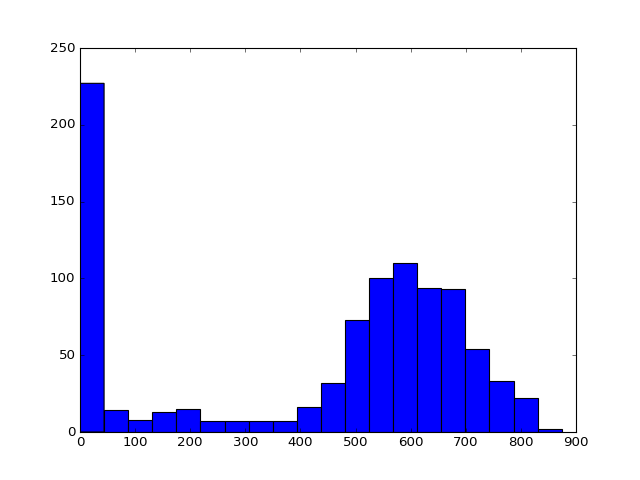

In [4]:
import %matplotlibotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.hist(prob_lens,20)
plt.show()

In [7]:
sum([prob_len>500 for prob_len in prob_lens])

557

In [8]:
len(prob_lens)

934

# 3. Post Processing

## 3.1 keep 500 probes in the center

In [30]:
# Used directories
region_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-14/chr21';
report_dir = r'/reports/merged'; # if merged
# Save directory
report_folder = region_folder + report_dir;
save_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged' # if merged
if not os.path.exists(save_folder):
    os.makedirs(save_folder);
# get previous outputs
max_pb_num = 500;
min_pb_num = 1;
files = glob.glob(report_folder+os.sep+r'*.pbr')
total_prob_num = 0;
for _file in sorted(files):
    # load probe report
    pbde = ld.pb_reports_class()
    pbde.load_pbr(_file)
    #change save file directory
    pbde.save_file = save_folder + os.sep + os.path.basename(pbde.save_file);
    # check length
    if len(pbde.pb_reports_keep) < min_pb_num:
        continue
    else:
        if len(pbde.pb_reports_keep) > max_pb_num:
            # get region length
            _start, _end = pbde.pb_reports_keep.values()[0]['reg_name'].split(':')[1].split('_')[0].split('-')
            _reg_len = int(_end) - int(_start)
            # initialize centered_dic
            centered_pb_dic = {}
            ct = 0;
            for key, value in sorted(pbde.pb_reports_keep.items(), key=lambda (k,v): abs(v['pb_index']-int(_reg_len/2))):
                centered_pb_dic[key] = value;
                ct += 1;
                if ct >= max_pb_num:
                    break
            pbde.pb_reports_keep = centered_pb_dic # during saving, its automatically sorted, so I didn't sort it again
        total_prob_num += len(pbde.pb_reports_keep); # save total probe number
        print os.path.basename(pbde.save_file)+": "+str(len(pbde.pb_reports_keep));
        pbde.save_csv()
        pbde.save_pbrs()
        pbde.plots()
print "- Total probe number:", total_prob_num;

reg_101.pbr: 343
reg_102.pbr: 399
reg_103.pbr: 500
reg_104.pbr: 133
reg_105.pbr: 53
reg_106.pbr: 10
reg_107.pbr: 10
reg_108.pbr: 3
reg_120.pbr: 138
reg_121.pbr: 370
reg_122.pbr: 465
reg_123.pbr: 454
reg_124.pbr: 104
reg_128.pbr: 64
reg_129.pbr: 186
reg_130.pbr: 441
reg_131.pbr: 257
reg_132.pbr: 278
reg_136.pbr: 1
reg_137.pbr: 7
reg_138.pbr: 15
reg_139.pbr: 35
reg_145.pbr: 8
reg_146.pbr: 11
reg_147.pbr: 4
reg_155.pbr: 56
reg_156.pbr: 363
reg_157.pbr: 281
reg_158.pbr: 54
reg_159.pbr: 65
reg_160.pbr: 21
reg_161.pbr: 3
reg_165.pbr: 1
reg_166.pbr: 8
reg_168.pbr: 8
reg_169.pbr: 3
reg_171.pbr: 4
reg_172.pbr: 5
reg_173.pbr: 20
reg_174.pbr: 6
reg_175.pbr: 3
reg_176.pbr: 27
reg_177.pbr: 10
reg_178.pbr: 4
reg_180.pbr: 105
reg_181.pbr: 85
reg_182.pbr: 51
reg_183.pbr: 9
reg_184.pbr: 10
reg_185.pbr: 2
reg_186.pbr: 1
reg_187.pbr: 3
reg_188.pbr: 3
reg_191.pbr: 22
reg_192.pbr: 74
reg_193.pbr: 44
reg_194.pbr: 78
reg_195.pbr: 216
reg_196.pbr: 386
reg_197.pbr: 106
reg_198.pbr: 69
reg_199.pbr: 51
reg_200.p

reg_669.pbr: 291
reg_670.pbr: 213
reg_671.pbr: 495
reg_672.pbr: 500
reg_673.pbr: 462
reg_674.pbr: 500
reg_675.pbr: 490
reg_676.pbr: 500
reg_677.pbr: 500
reg_678.pbr: 500
reg_679.pbr: 500
reg_680.pbr: 500
reg_681.pbr: 500
reg_682.pbr: 500
reg_683.pbr: 500
reg_684.pbr: 500
reg_685.pbr: 500
reg_686.pbr: 500
reg_687.pbr: 500
reg_688.pbr: 480
reg_689.pbr: 297
reg_690.pbr: 259
reg_691.pbr: 500
reg_692.pbr: 500
reg_693.pbr: 500
reg_694.pbr: 500
reg_695.pbr: 500
reg_696.pbr: 500
reg_697.pbr: 500
reg_698.pbr: 500
reg_699.pbr: 500
reg_700.pbr: 500
reg_701.pbr: 500
reg_702.pbr: 500
reg_703.pbr: 500
reg_704.pbr: 500
reg_705.pbr: 500
reg_706.pbr: 500
reg_707.pbr: 500
reg_708.pbr: 500
reg_709.pbr: 500
reg_710.pbr: 500
reg_711.pbr: 500
reg_712.pbr: 500
reg_713.pbr: 500
reg_714.pbr: 500
reg_715.pbr: 500
reg_716.pbr: 500
reg_717.pbr: 500
reg_718.pbr: 500
reg_719.pbr: 500
reg_720.pbr: 500
reg_721.pbr: 500
reg_722.pbr: 500
reg_723.pbr: 395
reg_724.pbr: 500
reg_725.pbr: 500
reg_726.pbr: 447
reg_727.pbr: 3

## 3.2 Assign region into TADs

In [33]:
def Match_TADs(master_folder, TAD_ref, report_folder,
              verbose=True, save=True):
    '''Function to match regions with a TAD reference
    Input: 
    master_folder: master directory for the whole dataset, string
    TAD_ref: filename for TAD reference, string
    report_folder: directory for probe reports, string'''
    import os, glob, sys
    import LibraryDesigner as ld
    import numpy as np
    import cPickle as pickle
    
    def Read_TAD_ref(master_folder=master_folder, TAD_ref=TAD_ref):
        _tad_dics = [];
        with open(master_folder+os.sep+TAD_ref) as _ref_handle:
            _lines = _ref_handle.readlines();
            for _line in _lines:
                _chrom = _line.split(':')[0]
                _reg_str = _line.split(':')[1].split('\n')[0];
                _start,_stop = _reg_str.split('-');
                _tad_dic = {'chr':_chrom, 'start':int(_start), 'stop':int(_stop)}
                _tad_dics.append(_tad_dic);
        return sorted(_tad_dics, key=lambda d:d['start']);
    
    def Region_to_TAD(tad_dics, report_filename):
        _pb = ld.pb_reports_class()
        _pb.load_pbr(report_filename)
        # get its region status
        _reg_id = int(_pb.pb_reports_keep.values()[0]['reg_name'].split('reg')[1].split('_')[1])
        _chrom = _pb.pb_reports_keep.values()[0]['reg_name'].split(':')[0]
        _start, _stop = _pb.pb_reports_keep.values()[0]['reg_name'].split(':')[1].split('_')[0].split('-')
        _start = int(_start);
        _stop = int(_stop);
        if _start > _stop:
            _start, _stop = _stop, _start
        _reg_len = abs(_stop - _start)
        # initialize tad identity of this region
        _tad_id = -1;
        for i in range(len(tad_dics)):
            _dic = tad_dics[i];
            if _chrom == _dic['chr']:
                _overlap = min(_stop, _dic['stop']) - max(_start, _dic['start']);
                if _overlap > _reg_len / 2:
                    _tad_id = i; # assign tad id
                    break
    
        return _reg_id, _tad_id, len(_pb.pb_reports_keep)
    
    def Extra_Region_Assigning(tad_id_dic):
        '''Try to assign region to TADs as much as possible
        '''
        # calculate how many region has been assigned to each TAD
        _v,_c = np.unique(tad_id_dic.values(),return_counts=True)
        _reg_num_dic = dict(zip(_v,_c)) # dictionary for region number of each TAD

        # maximum gap size to be filled
        _gap_max = 4 

        # new_id_dic
        _new_id_dic = tad_id_dic.copy();

        # Starting filling gaps!
        _gap = 0;
        _prev_value = -1;
        for _key, _value in sorted(_new_id_dic.items()):
            # start a gap 
            if _gap == 0 and _value == -1: 
                _prev_tad = _prev_value
                _gap = 1; # turn on gap
                _key_ingap = [_key] # start recording keys in gap

            # continue a gap
            elif _gap == 1 and _value == -1:
                _key_ingap.append(_key)

            # stop a gap!
            elif _gap == 1 and _value > -1:
                _gap = 0; # stop counting gap
                _next_tad = _value 
                # if the gap is not huge, try to make up
                if len(_key_ingap) <= _gap_max: 
                    if _prev_tad == -1: # don't fill any gap at beginning
                        continue 
                    elif len(_key_ingap)/2*2 == len(_key_ingap): # gap size is even number
                        for i in range(len(_key_ingap)/2):
                            _new_id_dic[_key_ingap[i]] = _prev_tad
                            _new_id_dic[_key_ingap[i+len(_key_ingap)/2]] = _next_tad
                    else: # gap size is odd number
                        for i in range(len(_key_ingap)/2):
                            _new_id_dic[_key_ingap[i]] = _prev_tad
                            _new_id_dic[_key_ingap[i+len(_key_ingap)/2+1]] = _next_tad
                        if _reg_num_dic[_prev_tad] <= _reg_num_dic[_next_tad]:
                            _new_id_dic[_key_ingap[len(_key_ingap)/2]] = _prev_tad
                        else:
                            _new_id_dic[_key_ingap[len(_key_ingap)/2]] = _next_tad

            _prev_value = _value # store previous tad info

        return _new_id_dic   
    
    def Save_dics(master_folder, tad_dics, reg_len_dic, new_id_dic):
        # save tad dics
        tad_dic_file = open(master_folder+os.sep+'TAD_dic_list.pkl','w');
        pickle.dump(tad_dics, tad_dic_file);
        tad_dic_file.close()
        # save region length dic
        reg_len_dic_file = open(master_folder+os.sep+'region_length.pkl','w');
        pickle.dump(reg_len_dic, reg_len_dic_file);
        reg_len_dic_file.close()        
        # save region_to_tad dic
        reg_to_tad_file = open(master_folder+os.sep+'region_to_TAD.pkl','w');
        pickle.dump(new_id_dic, reg_to_tad_file);
        reg_to_tad_file.close() 

    if verbose:
        print '- Start reading TAD reference', TAD_ref
    tad_dics = Read_TAD_ref()
    
    if verbose:
        print '- Start reading probe reports'

    files = glob.glob(report_folder+os.sep+r'*.pbr')
    tad_id_dic = {} # store assigned tad id
    reg_len_dic = {} # store number of probes in each region
    
    for _file in sorted(files):
        reg_id, tad_id, reg_len = Region_to_TAD(tad_dics, _file)
        tad_id_dic[reg_id] = tad_id; # update tad id dic
        reg_len_dic[reg_id] = reg_len; # update region length dic
        if verbose:
            print '--', os.path.basename(_file), 'tad_id:', tad_id, 'size:', reg_len

            
    new_id_dic = Extra_Region_Assigning(tad_id_dic)
    
    if save:
        Save_dics(master_folder=master_folder,
                 tad_dics=tad_dics,
                 reg_len_dic=reg_len_dic,
                 new_id_dic=new_id_dic);

    
    return tad_dics, tad_id_dic, reg_len_dic, new_id_dic

In [34]:
master_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21';
report_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged'; # if merged

tad_dics, tad_id_dic, reg_len_dic, new_id_dic= Match_TADs(master_folder,
                                                          TAD_ref='chr21_TADs.bed', 
                                                          report_folder=report_folder)

- Start reading TAD reference chr21_TADs.bed
- Start reading probe reports
-- reg_101.pbr tad_id: -1 size: 343
-- reg_102.pbr tad_id: -1 size: 399
-- reg_103.pbr tad_id: -1 size: 500
-- reg_104.pbr tad_id: -1 size: 133
-- reg_105.pbr tad_id: -1 size: 53
-- reg_106.pbr tad_id: -1 size: 10
-- reg_107.pbr tad_id: -1 size: 10
-- reg_108.pbr tad_id: -1 size: 3
-- reg_120.pbr tad_id: -1 size: 138
-- reg_121.pbr tad_id: -1 size: 370
-- reg_122.pbr tad_id: -1 size: 465
-- reg_123.pbr tad_id: -1 size: 454
-- reg_124.pbr tad_id: -1 size: 104
-- reg_128.pbr tad_id: -1 size: 64
-- reg_129.pbr tad_id: -1 size: 186
-- reg_130.pbr tad_id: -1 size: 441
-- reg_131.pbr tad_id: -1 size: 257
-- reg_132.pbr tad_id: -1 size: 278
-- reg_136.pbr tad_id: -1 size: 1
-- reg_137.pbr tad_id: -1 size: 7
-- reg_138.pbr tad_id: -1 size: 15
-- reg_139.pbr tad_id: -1 size: 35
-- reg_145.pbr tad_id: -1 size: 8
-- reg_146.pbr tad_id: -1 size: 11
-- reg_147.pbr tad_id: -1 size: 4
-- reg_155.pbr tad_id: -1 size: 56
-- reg_

-- reg_414.pbr tad_id: 3 size: 500
-- reg_415.pbr tad_id: 3 size: 500
-- reg_416.pbr tad_id: 3 size: 500
-- reg_417.pbr tad_id: -1 size: 500
-- reg_418.pbr tad_id: -1 size: 500
-- reg_419.pbr tad_id: -1 size: 500
-- reg_420.pbr tad_id: 4 size: 500
-- reg_421.pbr tad_id: 4 size: 500
-- reg_422.pbr tad_id: 4 size: 500
-- reg_423.pbr tad_id: 4 size: 500
-- reg_424.pbr tad_id: 4 size: 500
-- reg_425.pbr tad_id: 4 size: 500
-- reg_426.pbr tad_id: 4 size: 500
-- reg_427.pbr tad_id: 4 size: 474
-- reg_428.pbr tad_id: 4 size: 500
-- reg_429.pbr tad_id: 4 size: 500
-- reg_430.pbr tad_id: 4 size: 500
-- reg_431.pbr tad_id: 4 size: 500
-- reg_432.pbr tad_id: 4 size: 474
-- reg_433.pbr tad_id: 4 size: 500
-- reg_434.pbr tad_id: 4 size: 500
-- reg_435.pbr tad_id: 4 size: 500
-- reg_436.pbr tad_id: 4 size: 500
-- reg_437.pbr tad_id: 4 size: 500
-- reg_438.pbr tad_id: 4 size: 500
-- reg_439.pbr tad_id: 4 size: 500
-- reg_440.pbr tad_id: 4 size: 500
-- reg_441.pbr tad_id: 4 size: 468
-- reg_442.pbr ta

-- reg_647.pbr tad_id: 13 size: 500
-- reg_648.pbr tad_id: 13 size: 500
-- reg_649.pbr tad_id: 13 size: 500
-- reg_650.pbr tad_id: 13 size: 500
-- reg_651.pbr tad_id: 13 size: 500
-- reg_652.pbr tad_id: 13 size: 500
-- reg_653.pbr tad_id: 13 size: 500
-- reg_654.pbr tad_id: -1 size: 500
-- reg_655.pbr tad_id: -1 size: 500
-- reg_656.pbr tad_id: -1 size: 410
-- reg_657.pbr tad_id: 14 size: 385
-- reg_658.pbr tad_id: 14 size: 500
-- reg_659.pbr tad_id: 14 size: 500
-- reg_660.pbr tad_id: 14 size: 500
-- reg_661.pbr tad_id: 14 size: 500
-- reg_662.pbr tad_id: 14 size: 500
-- reg_663.pbr tad_id: 14 size: 500
-- reg_664.pbr tad_id: 14 size: 500
-- reg_665.pbr tad_id: 14 size: 500
-- reg_666.pbr tad_id: 14 size: 500
-- reg_667.pbr tad_id: 14 size: 500
-- reg_668.pbr tad_id: 14 size: 500
-- reg_669.pbr tad_id: 14 size: 291
-- reg_670.pbr tad_id: 14 size: 213
-- reg_671.pbr tad_id: -1 size: 495
-- reg_672.pbr tad_id: 15 size: 500
-- reg_673.pbr tad_id: 15 size: 462
-- reg_674.pbr tad_id: 15 si

-- reg_875.pbr tad_id: 28 size: 500
-- reg_876.pbr tad_id: 28 size: 500
-- reg_877.pbr tad_id: 29 size: 500
-- reg_878.pbr tad_id: 29 size: 500
-- reg_879.pbr tad_id: 29 size: 500
-- reg_880.pbr tad_id: 29 size: 500
-- reg_881.pbr tad_id: 29 size: 500
-- reg_882.pbr tad_id: 29 size: 500
-- reg_883.pbr tad_id: 30 size: 500
-- reg_884.pbr tad_id: 30 size: 400
-- reg_885.pbr tad_id: 30 size: 433
-- reg_886.pbr tad_id: 30 size: 500
-- reg_887.pbr tad_id: 30 size: 500
-- reg_888.pbr tad_id: 30 size: 500
-- reg_889.pbr tad_id: 30 size: 500
-- reg_890.pbr tad_id: 30 size: 500
-- reg_891.pbr tad_id: 30 size: 500
-- reg_892.pbr tad_id: 30 size: 500
-- reg_893.pbr tad_id: 30 size: 500
-- reg_894.pbr tad_id: 30 size: 500
-- reg_895.pbr tad_id: 30 size: 500
-- reg_896.pbr tad_id: 30 size: 500
-- reg_897.pbr tad_id: 31 size: 500
-- reg_898.pbr tad_id: 31 size: 500
-- reg_899.pbr tad_id: 31 size: 500
-- reg_900.pbr tad_id: 31 size: 500
-- reg_901.pbr tad_id: 31 size: 500
-- reg_902.pbr tad_id: 31 si

## 3.3 Assign color and cluster id

In [40]:
# You can continue here!
region_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21';

# dic for region -> tad
if not 'new_id_dic' in vars():
    print "-- loading reg-tad-dic"
    new_id_dic = pickle.load(open(region_folder+os.sep+'region_to_TAD.pkl','r'))
reg_id_dic = new_id_dic

# dic for region -> it's length
if not 'reg_len_dic' in vars():
    print "-- loading reg-size-dic"
    reg_len_dic = pickle.load(open(region_folder+os.sep+'region_length.pkl','r'))
reg_size_dic = reg_len_dic

In [66]:
def Design_Encoding(reg_id_dic, reg_size_dic, size_threshold=200,
                    n_color=3,
                    n_reg=10, n_hyb=5, min_region_times=2,
                    filling_rows=True,
                    save=True, save_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21',
                    verbose=True):
    '''Design encoding scheme
    Inputs:
        reg_id_dic: region -> TAD dictionary, dic
        reg_size_dic: region -> number of probe dictionary, dic
        size_threshold: lower bound for number of probes in each region, int
        n_color: number of colors, int
        n_reg: number of region per decoding unit, int
        n_hyb: number of hybes per decoding unit, int
        min_region_times: minimum region appearing times, int
        filling_rows: whether I should fill remaining region into last row, bool
        save: whether save final result, bool
        save_folder: save directory, string
        verbose: whether say something!, bool
    Output:
        reg_encoding: region_number -> color=i, cluster=j, region=k, barcodes->...
        hyb_matrix: hybridization matrix, n_reg by n_hyb
        assign_regs: matrix of assigning region to clusters, n_color by n_cluster by n_reg
        assign_tads: matrix of assigning tad to clusters, n_color by n_cluster by n_reg
        '''
    # imports
    import numpy as np;
    
    def _TAD_to_Region(reg_id_dic, _reg_size_dic=reg_size_dic, _size_threshold=size_threshold, _verbose=verbose):
        '''Function to inverse region->TAD dictionary'''
        if _verbose:
            print '-- Converting region->TAD dic into TAD->[regions]';
            
        _tad_to_region = {}
        for k, v in reg_id_dic.iteritems():
            if value >= 0 and _reg_size_dic[k] > _size_threshold:
                _tad_to_region[v] = _tad_to_region.get(v, [])
                _tad_to_region[v].append(k)   
        _tad_to_region.pop(-1, None);
        
        if _verbose:
            for k,v in sorted(_tad_to_region.items()):
                print '---TAD: '+str(k);
                print v;
                
        
        return _tad_to_region;

    def _Generate_Hyb_Matrix(n_reg=n_reg, n_hyb=n_hyb, min_region_times=min_region_times, _verbose=verbose):
        '''Function to generate hybridization matrix
        Input: number of regions
               number of hybridizations
               the minimal time that each region appears. default:1
        Output: A hybridization matrix'''
        if _verbose:
            print '-- Generating hybridization matrix for region='+str(n_reg)+', hyb='+str(n_hyb);        
        
        # generate all possible all_codess
        all_codes =[] # list for all possible binary all_codess
        for i in range(2**n_hyb):
            hybe_0 = np.zeros(n_hyb,dtype=int)
            binrep = [int(c) for c in str("{0:#b}".format(i))[2:]]
            #print str("{0:#b}".format(i))[2:]
            hybe_0[-len(binrep):]=binrep
            all_codes.append(hybe_0)
        all_codes = np.array(all_codes)
        all_codes = all_codes[np.sum(all_codes,-1)>0]
        # Choose candicate codes
        _code_sums = np.sum(all_codes,axis=-1) 
        _code_sums[_code_sums < min_region_times]=np.max(_code_sums)+1 # remove codes that dont satisfy minimal region showup times
        _max_region_time = np.sort(_code_sums)[n_reg] # maximum region appearance
        if min_region_times == _max_region_time: # Case 1: all regions has the same code
            _nchoose = n_reg
            _cand_codes = all_codes[_code_sums == _max_region_time];
            _sims = []
            for _i in range(20000):
                _sim = _cand_codes[np.random.choice(range(len(_cand_codes)), _nchoose, replace=False)]
                _sims.append(_sim)
            _sim_keep = _sims[np.argmin([np.var(np.sum(_sim,axis=0)) for _sim in _sims])]
            _hyb_matrix = np.array(list(_sim_keep))
        else:  # Case 2: use lower-choose codes first, and then use higher codes
            _used_codes = list(all_codes[_code_sums < _max_region_time]) # use up all shorter codes
            _nchoose = n_reg-len(_used_codes) # other codes to be chosen
            _cand_codes = all_codes[_code_sums == _max_region_time]
            _sims = []
            for _i in range(20000):
                _sim = _cand_codes[np.random.choice(range(len(_cand_codes)), _nchoose, replace=False)]
                _sims.append(_sim)
            _sim_keep = _sims[np.argmin([np.var(np.sum(_sim,axis=0)) for _sim in _sims])]
            _used_codes+=list(_sim_keep)
            _hyb_matrix = np.array(_used_codes).astype(np.int)

        return _hyb_matrix
    
    def _Assign_Color(_reg_encodings, _tad_to_region, _n_color=n_color, _verbose=verbose):
        if _verbose:
            print '-- Assigning colors for all regions';
        _reg_colors = [[] for _color in range(_n_color)]
        _mode_counter = 0; # used for balancing mode_n results into n categories
        for _k,_v in _tad_to_region.iteritems():
            for _color in range(_n_color):
                _reg_list = _v[(_mode_counter+_color)%_n_color::_n_color];
                _reg_colors[_color].append(_reg_list);
                for _reg in _reg_list:
                    _reg_encodings[_reg]['color'] = _color
            _mode_counter += 1;
        if _verbose:
            for _color in range(_n_color):
                lstlen=0
                for lst in _reg_colors[_color]:
                    lstlen += len(lst)
                print '--- Number of regions in color '+str(_color)+':', lstlen
        return _reg_encodings, _reg_colors;

    def _Assign_Cluster(reg_encodings, reg_colors, n_reg=n_reg, n_color=n_color, 
                        _filling_rows=filling_rows, _verbose=verbose):
        '''Assign regions into clusters'''
        from math import ceil
        from copy import copy
        if _verbose:
            print '-- Assigning clusters for all regions';
            
        # calculate number of clusters in each color
        n_cluster = int(ceil(len(reg_encodings)/float(n_color*n_reg)))
        # initialize matrix
        _assign_regs = -np.ones([n_color, n_cluster, n_reg],dtype=np.int)

        for _color in range(n_color):
            _rlist = copy(sorted(reg_colors[_color],key=lambda v:-len(v)));
            _cluster = 0;
            while len(_rlist) >= n_reg:
                for _reg in range(n_reg):
                    _assign_regs[_color, _cluster, _reg] = _rlist[_reg].pop(0)
                    # store into reg_encodings
                    reg_encodings[_assign_regs[_color, _cluster, _reg]]['color'] = _color;
                    reg_encodings[_assign_regs[_color, _cluster, _reg]]['cluster'] = _cluster;
                    reg_encodings[_assign_regs[_color, _cluster, _reg]]['region'] = _reg;
                # clean all empty lists
                while [] in _rlist:
                    _rlist.remove([]);
                # sort again
                _rlist = sorted(_rlist, key=lambda v:-len(v));
                # next cluster
                _cluster += 1
            # for the left regions, store then in the last row
            if _filling_rows:
                _assign_regs[_color, _cluster, :len(_rlist)] = np.array(_rlist).reshape(-1) # store the rest
                for _left_reg in range(len(_rlist)):
                    reg_encodings[_assign_regs[_color, _cluster, _left_reg]]['color'] = _color;
                    reg_encodings[_assign_regs[_color, _cluster, _left_reg]]['cluster'] = _cluster;
                    reg_encodings[_assign_regs[_color, _cluster, _left_reg]]['region'] = _left_reg;        
        
        return reg_encodings, _assign_regs;
    
    def _Assign_Decoding_Barcodes(reg_encodings, assign_regs, hyb_matrix,
                                  n_color=n_color, n_reg=n_reg, n_hyb=n_hyb, _verbose=verbose):
        '''Assign barcode (orders) used for decoding'''
        if _verbose:
            print '-- Assigning decoding barcodes.'        
        # Sanity check
        if np.shape(assign_regs)[0] != n_color or np.shape(assign_regs)[2] != n_reg:
            raise EOFError('wrong input dimension!');
        # collect number of clusters per color
        n_cluster = np.shape(assign_regs)[1];
        _barcode_set = 0; # barcode to be assigned
        for _color in range(n_color):
            for _cluster in range(n_cluster):
                for _reg in range(n_reg):
                    if assign_regs[_color,_cluster,_reg] >= 0:
                        reg_encodings[assign_regs[_color,_cluster,_reg]]['bc_decoding'] = [n_hyb*_barcode_set+ i for i, j in enumerate(hyb_matrix[_reg]) if j == 1]
                _barcode_set += 1; # next barcode set (size of n_hyb)
        return reg_encodings;
    
    def _Check_Decoding_Barcodes(reg_encodings, hyb_matrix, _verbose=verbose):
        '''Function to check whether decoding barcode works fine'''
        if _verbose:
            print '--- Checking decoding barcodes.'  
        reg_bc_num=hyb_matrix.sum(1).max()
        hyb_bc_num=hyb_matrix.sum(0).max()   
        bc_list = [];
        for k,v in reg_encodings.iteritems():
            if len(v['bc_decoding']) > reg_bc_num or len(v['bc_decoding']) <=0:
                print '--- wrong barcode size per region';
                return False
            bc_list += v['bc_decoding'];
        # record unique barcodes
        barcodes, barcode_counts = np.unique(bc_list, return_counts=True)
        print barcodes
        # check barcode usage per hybe
        validate = False not in [n<=hyb_bc_num and n>0 for n in barcode_counts]
        print '---', validate
        return validate

    def _Assign_TAD_Barcodes(reg_encodings, _verbose=verbose):
        '''Assign barcode (orders) used for TAD identity'''
        if _verbose:
            print '-- Assigning TAD barcodes.' 
        # record all decoding barcodes
        dec_bcs = []
        for k,v in reg_encodings.iteritems():
            dec_bcs += v['bc_decoding']
        # tad barcodes should start right after
        tad_bc_start = max(dec_bcs)+1; 
        for k,v in reg_encodings.iteritems():
            if v['TAD']>=0:
                reg_encodings[k]['bc_tad'] = reg_encodings[k]['TAD'] + tad_bc_start;
        
        return reg_encodings
        
            
    def _Assign_Unique_Barcodes(reg_encodings, _verbose=verbose):
        '''Assign barcode (orders) used for unique sequential'''
        if _verbose:
            print '-- Assigning unique barcodes.'
        # record all decoding barcodes and TAD barcodes
        used_bcs = []
        for k,v in reg_encodings.iteritems():
            used_bcs += v['bc_decoding']
            used_bcs += [v['bc_tad']]
        # unique barcodes should start right after
        unique_bc_start = max(used_bcs); 
        reg_new_id = 1;
        for k,v in sorted(reg_encodings.items()):
            reg_encodings[k]['bc_unique'] = reg_new_id + unique_bc_start;
            reg_encodings[k]['id'] = reg_new_id;
            reg_new_id += 1;
        
        return reg_encodings  
    
    
    # Initialize
    if verbose:
        print "- Initializing";
    reg_encodings = {};
    for key, value in reg_id_dic.items():
        if value >= 0 and reg_size_dic[key] >= size_threshold: 
            reg_encodings[key] = {'TAD':value, 'id':None, 'color':None, \
                                  'cluster':None, 'region': None, \
                                  'bc_decoding':None,\
                                  'bc_tad':None, 'bc_unique':None}
    

    # creat tad to region dictionary
    if verbose:
        print "- Inverting region_to_tad dictionary";
    tad_to_region = _TAD_to_Region(reg_id_dic);
    
    # generate hybe matrix
    if verbose:
        print "- Prepare hyb matrix";
    hyb_matrix = _Generate_Hyb_Matrix()
    
    if verbose:
        print "- Calculate color, cluster assignment";    
    # assign colors
    reg_encodings , reg_colors = _Assign_Color(reg_encodings, tad_to_region);
    # assign cluster
    reg_encodings, assign_regs = _Assign_Cluster(reg_encodings, reg_colors);

    
    if verbose:
        print "- Assign barcodes";    
    # assign decoding barcodes
    reg_encodings = _Assign_Decoding_Barcodes(reg_encodings, assign_regs, hyb_matrix)
    # check decoding barcodes
    decoding_check = _Check_Decoding_Barcodes(reg_encodings, hyb_matrix)
    # assign TAD barcodes
    reg_encodings = _Assign_TAD_Barcodes(reg_encodings)
    # assign unique barcodes
    reg_encodings = _Assign_Unique_Barcodes(reg_encodings)    
    
    
    if save:
        import cPickle as pickle
        import os
        # mkdir if not exist for save folder
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        save_filename = save_folder + os.sep + 'total_encoding.pkl';
        if verbose:
            print "- Save to file:", save_filename
        savefile = open(save_filename, 'w');
        pickle.dump(reg_encodings, savefile)
        
    return reg_encodings, hyb_matrix, assign_regs

    
def Design_Noncoding_Sequential(reg_id_dic, reg_size_dic, threshold=200,
                                n_color=3, save=True, verbose=True):
    pass

In [67]:
reg_encodings, hyb_matrix, assign_regs = Design_Encoding(reg_id_dic=reg_id_dic, reg_size_dic=reg_size_dic, 
                                                         save_folder=region_folder);

- Initializing
- Inverting region_to_tad dictionary
-- Converting region->TAD dic into TAD->[regions]
---TAD: 0
[209, 211, 213]
---TAD: 1
[266, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317]
---TAD: 2
[318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361]
---TAD: 3
[362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418]
---TAD: 4
[419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 445, 446, 447, 448, 449, 450

In [68]:
reg_encodings

{209: {'TAD': 0,
  'bc_decoding': [105, 109],
  'bc_tad': 330,
  'bc_unique': 364,
  'cluster': 21,
  'color': 0,
  'id': 1,
  'region': 6},
 211: {'TAD': 0,
  'bc_decoding': [217, 218],
  'bc_tad': 330,
  'bc_unique': 365,
  'cluster': 21,
  'color': 1,
  'id': 2,
  'region': 2},
 213: {'TAD': 0,
  'bc_decoding': [325, 327],
  'bc_tad': 330,
  'bc_unique': 366,
  'cluster': 21,
  'color': 2,
  'id': 3,
  'region': 8},
 266: {'TAD': 1,
  'bc_decoding': [222, 223],
  'bc_tad': 331,
  'bc_unique': 367,
  'cluster': 0,
  'color': 2,
  'id': 4,
  'region': 2},
 281: {'TAD': 1,
  'bc_decoding': [2, 3],
  'bc_tad': 331,
  'bc_unique': 368,
  'cluster': 0,
  'color': 0,
  'id': 5,
  'region': 2},
 282: {'TAD': 1,
  'bc_decoding': [111, 114],
  'bc_tad': 331,
  'bc_unique': 369,
  'cluster': 0,
  'color': 1,
  'id': 6,
  'region': 3},
 283: {'TAD': 1,
  'bc_decoding': [227, 228],
  'bc_tad': 331,
  'bc_unique': 370,
  'cluster': 1,
  'color': 2,
  'id': 7,
  'region': 2},
 284: {'TAD': 1,
  'b

## 3.4 Design sub library encoding

In [69]:
def Sub_Library_Encoding(total_encoding, hyb_matrix, assign_regs, reg_id_dic,
                         sub_library_size,
                         min_reg_in_tad=2, 
                         save=True, save_dir=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21',
                         continue_num=False,
                         verbose=True):
    '''Extract a sub library for total library and redesign encodings
    Inputs:
        _reg_encoding: region_number -> color=i, cluster=j, region=k, barcodes->...
        hyb_matrix: hybridization matrix, n_reg by n_hyb
        assign_regs: matrix of assigning region to clusters, n_color by n_cluster by n_reg
        reg_id_dic: dictionary for region -> tad, dic
        sub_library_size: number of regions in the sub library, int
        min_reg_in_tad: criteria for selecting sub library, at least 2 regions in each new tad, int
        save: whether save, bool
        save_dir: directory for saving, str
        continue_num: whether barcode id numbered continuously, False/'tad'/'decoding'/'all'
        verbose: whether say something!, bool
    Outputs:
        sub_encodings: encoding scheme for sub library
        other_encodings: encoding scheme for the rest of library
    '''
    # imports
    import numpy as np;
    
    def _TAD_in_Cluster(_assign_regs, reg_id_dic=reg_id_dic, _verbose=verbose):
        # input parameters
        n_color = _assign_regs.shape[0]; # number of colors
        n_cluster = _assign_regs.shape[1]; # number of clusters per color
        n_reg = _assign_regs.shape[2]; # number of regions, defined by hyb matrix
        
        _assign_tads = -np.ones(np.shape(_assign_regs), dtype=np.int)
        for _color in range(n_color):
            for _cluster in range(n_cluster):
                for _reg in range(n_reg):
                    if _assign_regs[_color, _cluster, _reg] >= 0:
                        _assign_tads[_color, _cluster, _reg] = reg_id_dic[_assign_regs[_color, _cluster, _reg]]
        
        return _assign_tads;
    
    def _Select_Sub_Encodings(total_encoding=total_encoding, assign_regs=assign_regs, 
                              sub_library_size=sub_library_size, min_reg_in_tad=min_reg_in_tad,
                              _verbose=verbose):
        if _verbose:
            print "-- Starting sub library searching";
        # convert assign_cluster into assign_tad
        assign_tads = _TAD_in_Cluster(assign_regs);

        # record parameters
        n_color = assign_regs.shape[0]; # number of colors
        n_cluster = assign_regs.shape[1]; # number of clusters per color
        n_reg = assign_regs.shape[2]; # number of regions, defined by hyb matrix
        _select_clusters = int(sub_library_size / n_reg) # number total selected clusters (in all colors)
        if _verbose:
            print "--- color: "+str(n_color), "cluster: "+str(n_cluster), "region: "+str(n_reg), "selected clusters: "+str(_select_clusters)
        # Split select clusters in different colors equally
        n_chooses = []
        for i in range(n_color):
            _choose =  (_select_clusters-sum(n_chooses)) / (n_color-i)
            n_chooses.append(_choose)
        n_chooses = sorted(n_chooses)
        n_chooses.reverse()
        # Randomly generate region picking
        j=0
        min_reg = 0;
        while min_reg < min_reg_in_tad:
            _cids = []; # chosen id list
            _ctads = []; # chosen tad matrix parts
            for i in range(n_color):
                # chosen ids
                _cids.append([sorted(np.random.choice(n_cluster-1, n_chooses[i], replace=False))])
                # chosen tads
                _ctads.append(assign_tads[i, _cids[i], :]);
                # get unique set
                _tads, _cts = np.unique(np.concatenate(_ctads,1), return_counts=True);
            # start updating once all TADs show up
            if len(_tads) == len(np.unique(assign_tads[:,:-1,:])): 
                min_reg = np.min(_cts) # the minimum occurance of TADs
            j+=1;
        if _verbose:
            print "--- Number of searches:", j;
            print "-- Finishing library searching, constructing sub library";
        
        # Storing information into reg matrix
        _sub_regs = -np.ones([n_color, n_chooses[0], n_reg]);
        _other_regs = -np.ones([n_color, n_cluster-n_chooses[-1], n_reg]);
        for _color in range(n_color):
            _sub_regs[_color,:n_chooses[_color],:] = assign_regs[_color, _cids[_color],:] # sub region
            _oid = list(set(np.arange(n_cluster)) - set(sorted(np.random.choice(22,5,replace=False)))) #other region
            _other_regs[_color,:len(_oid),:] = assign_regs[_color, _oid, :];
        
        # Initialize encoding region list
        _sub_encodings, _other_encodings = {},{};
        for _r in np.unique(_sub_regs):
            if _r >=0:
                #_sub_encodings[int(_r)] = total_encoding[int(_r)];
                _sub_encodings[int(_r)] = {'TAD':total_encoding[int(_r)]['TAD'],
                                           'color':total_encoding[int(_r)]['color'],
                                           'cluster':None,
                                           'id':None,
                                           'region':total_encoding[int(_r)]['region'],
                                           'bc_decoding':None, 'bc_tad':None, 'bc_unique':None}
        for _r in np.unique(_other_regs):
            if _r >=0:
                #_other_encodings[int(_r)] = total_encoding[int(_r)];   
                _other_encodings[int(_r)] = {'TAD':total_encoding[int(_r)]['TAD'],
                                             'color':total_encoding[int(_r)]['color'],
                                             'cluster':None,
                                             'id':None,
                                             'region':total_encoding[int(_r)]['region'],
                                             'bc_decoding':None, 'bc_tad':None, 'bc_unique':None}

        return _sub_encodings, _sub_regs, _other_encodings, _other_regs
    
    
    def _Assign_All_Barcodes(_reg_encodings, _assign_regs, _hyb_matrix=hyb_matrix, 
                             _continue_num=continue_num, _verbose=verbose):
        '''Assembled function to update all barcodes'''
        # record parameters
        n_color = _assign_regs.shape[0]; # number of colors
        n_cluster = _assign_regs.shape[1]; # number of clusters per color
        n_reg = _assign_regs.shape[2]; # number of regions per cluster, defined by hyb matrix
        n_hyb = _hyb_matrix.shape[1]; # number of hybes per cluster
        if _verbose:
            print "--- color: "+str(n_color), "cluster: "+str(n_cluster), "region: "+str(n_reg),\
                "hybs: "+str(n_hyb);
        def _Assign_Decoding_Barcodes(_reg_encodings, _assign_regs=_assign_regs, _hyb_matrix=_hyb_matrix,
                                      n_color=n_color, n_cluster=n_cluster, 
                                      n_reg=n_reg, n_hyb=n_hyb, _verbose=verbose):
            '''Assign barcode (orders) used for decoding'''
            if _verbose:
                print '-- Assigning decoding barcodes.'        
            # Sanity check
            if np.shape(_assign_regs)[0] != n_color or np.shape(_assign_regs)[2] != n_reg:
                raise EOFError('wrong input dimension!');
            # collect number of clusters per color
            _barcode_set = 0; # barcode to be assigned
            for _color in range(n_color):
                for _cluster in range(n_cluster):
                    for _reg in range(n_reg):
                        if _assign_regs[_color,_cluster,_reg] >= 0:
                            _reg_encodings[_assign_regs[_color,_cluster,_reg]]['cluster'] = _cluster
                            _reg_encodings[_assign_regs[_color,_cluster,_reg]]['bc_decoding'] = [n_hyb*_barcode_set+i for i, j in enumerate(_hyb_matrix[_reg]) if j == 1]
                            #print [n_hyb*_barcode_set+i for i, j in enumerate(_hyb_matrix[_reg]) if j == 1]
                    _barcode_set += 1; # next barcode set (size of n_hyb)
            return _reg_encodings;

        def _Assign_TAD_Barcodes(_reg_encodings, _continue_num=_continue_num, _verbose=verbose):
            '''Assign barcode (orders) used for TAD identity'''
            if _verbose:
                print '-- Assigning TAD barcodes.' 
            # record all decoding barcodes
            dec_bcs = []
            for k,v in _reg_encodings.iteritems():
                dec_bcs += v['bc_decoding']
            # tad barcodes should start right after
            if _continue_num == 'all':
                tad_bc_start = max(dec_bcs)+1; 
            else:
                tad_bc_start = 0;
            for k,v in _reg_encodings.iteritems():
                if v['TAD']>=0:
                    _reg_encodings[k]['bc_tad'] = _reg_encodings[k]['TAD'] + tad_bc_start;

            return _reg_encodings

        def _Assign_Unique_Barcodes(_reg_encodings, _continue_num=_continue_num, _verbose=verbose):
            '''Assign barcode (orders) used for unique sequential'''
            if _verbose:
                print '-- Assigning unique barcodes.'

            # unique barcodes should start right after
            if _continue_num == 'tad':
                # record decoding TAD barcodes
                used_bcs = []
                for k,v in _reg_encodings.iteritems():
                    used_bcs += [v['bc_tad']]
                unique_bc_start = max(used_bcs)+1; 
            elif _continue_num == 'decoding':
                # record decoding barcodes barcodes
                used_bcs = []
                for k,v in _reg_encodings.iteritems():
                    used_bcs += v['bc_decoding']
                unique_bc_start = max(used_bcs)+1; 
            elif  _continue_num == 'all':              
                # record all decoding barcodes and TAD barcodes
                used_bcs = []
                for k,v in _reg_encodings.iteritems():
                    used_bcs += v['bc_decoding']
                    used_bcs += [v['bc_tad']]
                unique_bc_start = max(used_bcs)+1; 
            else:
                unique_bc_start = 0
                
            reg_new_id = 0;
            for k,v in sorted(_reg_encodings.items()):
                _reg_encodings[k]['bc_unique'] = reg_new_id + unique_bc_start;
                _reg_encodings[k]['id'] = reg_new_id;
                reg_new_id += 1;

            return _reg_encodings  
        
        # assign decoding barcodes
        _reg_encodings = _Assign_Decoding_Barcodes(_reg_encodings)
        # assign TAD barcodes
        _reg_encodings = _Assign_TAD_Barcodes(_reg_encodings, _continue_num=_continue_num)
        # assign unique barcodes
        _reg_encodings = _Assign_Unique_Barcodes(_reg_encodings, _continue_num=_continue_num)    
    
        return _reg_encodings
    
    
    # Select sub library
    if verbose:
        print "- Select sub library."
    sub_encodings, sub_regs, other_encodings, other_regs= _Select_Sub_Encodings()
    # Re_assign barcodes
    if verbose:
        print "- Reassign barcodes for sub library."
        print "-- continue numbering:", continue_num;
    sub_encodings = _Assign_All_Barcodes(sub_encodings, sub_regs);
    if verbose:
        print "- Reassign barcodes for the rest of library."
        print "-- continue numbering:", continue_num;
    other_encodings = _Assign_All_Barcodes(other_encodings, other_regs);    
    
    if save:
        import cPickle as pickle
        import os
        sub_filename = save_dir + os.sep + 'sub_encoding.pkl';
        other_filename = save_dir + os.sep + 'other_encoding.pkl';
        if verbose:
            print "- Save to file:", sub_filename, other_filename
        # save
        pickle.dump(sub_encodings, open(sub_filename,'w'))
        pickle.dump(other_encodings, open(other_filename,'w'))
    
    return sub_encodings, other_encodings

In [70]:
sub_encodings, other_encodings = Sub_Library_Encoding(reg_encodings, hyb_matrix, assign_regs, reg_id_dic, 150, 
                                                      min_reg_in_tad=2,
                                                      continue_num='tad',
                                                      save_dir=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21')

- Select sub library.
-- Starting sub library searching
--- color: 3 cluster: 22 region: 10 selected clusters: 15
--- Number of searches: 300
-- Finishing library searching, constructing sub library
- Reassign barcodes for sub library.
-- continue numbering: tad
--- color: 3 cluster: 5 region: 10 hybs: 5
-- Assigning decoding barcodes.
-- Assigning TAD barcodes.
-- Assigning unique barcodes.
- Reassign barcodes for the rest of library.
-- continue numbering: tad
--- color: 3 cluster: 17 region: 10 hybs: 5
-- Assigning decoding barcodes.
-- Assigning TAD barcodes.
-- Assigning unique barcodes.
- Save to file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/sub_encoding.pkl /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/other_encoding.pkl


## 3.5 Decoding barcode check

In [71]:
def _Check_Decoding_Barcodes(reg_encodings, hyb_matrix, _verbose=True):
    '''Function to check whether decoding barcode works fine'''
    if _verbose:
        print '--- Checking decoding barcodes.'  
    reg_bc_num=hyb_matrix.sum(1).max()
    hyb_bc_num=hyb_matrix.sum(0).max()   
    bc_list = [];
    for k,v in reg_encodings.iteritems():
        if len(v['bc_decoding']) > reg_bc_num or len(v['bc_decoding']) <=0:
            print '--- wrong barcode size per region';
            return False
        bc_list += v['bc_decoding'];
    # record unique barcodes
    barcodes, barcode_counts = np.unique(bc_list, return_counts=True)
    print barcodes
    print barcode_counts
    # check barcode usage per hybe
    validate = False not in [n<=hyb_bc_num and n>0 for n in barcode_counts]
    print '---', validate
    return validate
_Check_Decoding_Barcodes(sub_encodings, hyb_matrix)

--- Checking decoding barcodes.
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4]
--- True


True

In [100]:
sub_encodings

{266: {'TAD': 1,
  'bc_decoding': [52, 53],
  'bc_tad': 1,
  'bc_unique': 34,
  'cluster': 0,
  'color': 2,
  'id': 0,
  'region': 2},
 281: {'TAD': 1,
  'bc_decoding': [2, 3],
  'bc_tad': 1,
  'bc_unique': 35,
  'cluster': 0,
  'color': 0,
  'id': 1,
  'region': 2},
 299: {'TAD': 1,
  'bc_decoding': [7, 8],
  'bc_tad': 1,
  'bc_unique': 36,
  'cluster': 1,
  'color': 0,
  'id': 2,
  'region': 2},
 303: {'TAD': 1,
  'bc_decoding': [26, 29],
  'bc_tad': 1,
  'bc_unique': 37,
  'cluster': 0,
  'color': 1,
  'id': 3,
  'region': 3},
 307: {'TAD': 1,
  'bc_decoding': [57, 58],
  'bc_tad': 1,
  'bc_unique': 38,
  'cluster': 1,
  'color': 2,
  'id': 4,
  'region': 2},
 309: {'TAD': 1,
  'bc_decoding': [35, 38],
  'bc_tad': 1,
  'bc_unique': 39,
  'cluster': 2,
  'color': 1,
  'id': 5,
  'region': 7},
 312: {'TAD': 1,
  'bc_decoding': [40, 41],
  'bc_tad': 1,
  'bc_unique': 40,
  'cluster': 3,
  'color': 1,
  'id': 6,
  'region': 9},
 316: {'TAD': 1,
  'bc_decoding': [71, 73],
  'bc_tad': 1,


# 4. Patch Barcode Sequence to Reads

In [73]:
# minimal imports for biopython
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
import os,glob,time
import numpy as np

## 4.1 Read barcode Sequences

In [59]:
# read all Stv barcodes
barcode_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Barcodes';

#stv_adaptor = [1,2,17,62,77,78,79,80,81,82,83,84] # barcodes saved for adaptors
#stv_bad = [34,38,41] # barcodes performed badly
#stv_mask = stv_adaptor + stv_bad 
stv_mask = []

with open(barcode_dir+os.sep+'top_Stvs.fasta', "rU") as handle:
    stv_barcodes = [];
    for record in SeqIO.parse(handle, "fasta"):
        if int(record.id.split('_')[1]) not in stv_mask:
            stv_barcodes.append(record);

# read all NDB barcodes
ndb_mask = [];

with open(barcode_dir+os.sep+'NDBs.fasta', "rU") as handle:
    ndb_barcodes = [];
    for record in SeqIO.parse(handle, "fasta"):
        if int(record.id.split('_')[1]) not in ndb_mask:
            ndb_barcodes.append(record);
print "Barcodes loaded: Stv: "+str(len(stv_barcodes))+", NDB: "+str(len(ndb_barcodes));

Barcodes loaded: Stv: 75, NDB: 1052


## 4.2 Read all PCR primers

In [60]:
primer_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Primers';
fwd_primer_filename = 'forward_primers_keep.fasta';
rev_primer_filename = 'reverse_primers_keep.fasta';

# read all forward primers
with open(primer_dir+os.sep+fwd_primer_filename, "rU") as handle:
    fwd_primers = [];
    for record in SeqIO.parse(handle, "fasta"):
        fwd_primers.append(record);
# read all forward primers
with open(primer_dir+os.sep+rev_primer_filename, "rU") as handle:
    rev_primers = [];
    for record in SeqIO.parse(handle, "fasta"):
        rev_primers.append(record);
print "Primers loaded: forward: "+str(len(fwd_primers))+", reverse: "+str(len(rev_primers));        

Primers loaded: forward: 12, reverse: 9


## 4.3 read all probe reports and generate primary probes

### Important!
* Here I removed bc_tad

In [61]:
# Important inputs for patching barcodes
barcode_source = {'bc_unique':'ndb',
                  #'bc_tad': 'ndb',
                  'bc_decoding':'stv'};
barcode_order = ['bc_decoding', 'bc_unique'];

# master directory
master_dir =r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21';
report_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged'; # if merged
save_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/final_probes'; # if merged


# primer sets
fprimer = fwd_primers[8];
print '- forward primer:', fprimer
rprimer = rev_primers[6];
print '- reverse primer:', rprimer

# dic for sub-encoding scheme
if not 'sub_encodings' in vars():
    import cPickle as pickle
    print 'loading sub_encodings'
    sub_encodings = pickle.load(open(master_dir+os.sep+'sub_encoding.pkl','r'))

- forward primer: ID: W1B05_primer_16
Name: W1B05_primer_16
Description: W1B05_primer_16
Number of features: 0
Seq('CGGGTTTCGTTGCGCACACC', SingleLetterAlphabet())
- reverse primer: ID: W1B04_primer_15
Name: W1B04_primer_15
Description: W1B04_primer_15
Number of features: 0
Seq('TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA', SingleLetterAlphabet())


In [92]:
def Patch_Barcodes(reg_encodings, 
                   fwd_primer,rev_primer,
                   barcode_source, 
                   barcode_order,
                   stv_barcodes, ndb_barcodes, barcode_starts={'stv':1,'ndb':1},
                   report_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged',
                   save_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/final_probes',
                   add_rand_gap=0,
                   save=True, verbose=True):
    '''Function to patch barcodes to designed probes
    Inputs:
        reg_encodings: encoding scheme for the barcode, dictionary(generated previously)
        fwd_primer: forward primer,20mer, biopython SeqRecord
        rev_primer: reverse primer,40mer(rc), last 20mer-rc should be used
        barcode_source: dictionary to determine the source of barcodes, dictionary
        barcode_order: list to determine numbering order of barcodes, list
        stv_barcodes: old barcodes,30mer, biopython SeqRecord list
        ndb_barcodes: new barcodes,30mer, biopython SeqRecord list
        barcode_starts: id of the first unused barcode, dictionary
        report_folder: directory for probe reports, string
        save_folder: directory for save files, string
        add_rand_gap: whether adding (or length) of random gaps between barcodes, int
        save: whether save, bool
        verbose: whether say something, bool
    Outputs:
        total library SeqRecord
        '''
    # minimal imports
    from Bio import SeqIO
    from Bio.Seq import Seq
    from Bio.Alphabet import IUPAC
    from Bio.SeqRecord import SeqRecord 
    import numpy as np;
    import glob, os, sys, time
    import LibraryDesigner as ld
    
    # check inputs:
    if verbose:
        print "- Check inputs"
    # check barcode_source
    barcode_types = reg_encodings.values()[0].keys();
    for k, v in barcode_source.iteritems():
        if k not in barcode_types:
            raise ValueError('wrong barcode_source input!');
    # check barcode_order
    for _name in barcode_order:
        if _name not in barcode_types:
            raise ValueError('wrong barcode_order input!');
            
    # filter stv_barcodes and ndb_barcodes
    if verbose:
        print "- check barcode starts: ", barcode_starts
    _stv_barcodes, _ndb_barcodes = [],[];
    for record in stv_barcodes:
        if not int(record.id.split('_')[1]) < barcode_starts['stv']:
            _stv_barcodes.append(record)
    for record in ndb_barcodes:
        if not int(record.id.split('_')[1]) < barcode_starts['ndb']:
            _ndb_barcodes.append(record)
    
    def _generating_file_encoding(_report_folder=report_folder, 
                                  _reg_encodings=reg_encodings, _verbose=verbose):
        '''Convert region id encoding scheme into filename encoding scheme, change keys
        Inputs: 
            report_folder
            reg_encodings
            verbose
        Output:
            pb_files
            file_encodings'''
        # load probe reports:
        _pb_files = [fl for fl in glob.glob(_report_folder+os.sep+r'*.pbr') if int(os.path.basename(fl).split('_')[1].split('.')[0]) in _reg_encodings.keys()]
        if _verbose:
            print "- Load probe reports, total_num:", len(_pb_files);
        # save to file_encodings
        _file_encodings = {};
        for fl in _pb_files:
            _file_encodings[fl] = _reg_encodings[int(os.path.basename(fl).split('_')[1].split('.')[0])];
        
        return _pb_files, _file_encodings;
    

    
    def _patch_barcode_per_file(_file, _file_encodings, 
                                _fwd_primer=fwd_primer, _rev_primer=rev_primer,
                                _barcode_source=barcode_source, _stv_barcodes=stv_barcodes, _ndb_barcodes=ndb_barcodes,
                                _add_rand_gap=add_rand_gap, _verbose=verbose):
        from random import choice
        import os
        if _verbose:
            print "-- patch barcodes for:", _file
        # load probe report
        _pb = ld.pb_reports_class()
        _pb.load_pbr(_file)
        
        # extract encoding info:
        _encoding = _file_encodings[_file];
        
        # initialize, save all infos here
        _plist = [];
        _precords = [];
        for _info in _pb.pb_reports_keep.values():
            _tmp_info = _info.copy();

            # extract all encoding info from reg_encodings
            _tmp_info['reg_index'] = _encoding['id']
            _tmp_info['color'] = _encoding['color']
            if 'gene' in _encoding.keys():
                _tmp_info['gene'] = _encoding['gene']

            # extract barcode info
            _islist = False; # variable used for later design
            for _k,_v in _barcode_source.iteritems():
                if isinstance(_encoding[_k], list):
                    _islist = _k; # variable used for later design
                    _bcs = [];
                    for _bid in _encoding[_k]:
                        if _v == 'stv':
                            _bcs.append(_stv_barcodes[_bid]);
                        elif _v == 'ndb':
                            _bcs.append(_ndb_barcodes[_bid]);
                    _tmp_info[_k] = _bcs;
                else:
                    if _v == 'stv':
                        _tmp_info[_k] =_stv_barcodes[_encoding[_k]];
                    elif _v == 'ndb':
                        _tmp_info[_k] =_ndb_barcodes[_encoding[_k]];
            # extract primer info:
            _tmp_info['fwd_primer'] = _fwd_primer;
            _tmp_info['rev_primer'] = _rev_primer;

            ## generate_whole sequence
            # fwd_primer(20)
            # barcode 1 [from list, 1], (reverse-complement of last 20)
            # barcode 2, (reverse-complement of last 20)
            # target sequence
            # barcode 3, (reverse-complement of last 20)
            # barcode 4 [from list, 1], (reverse-complement of last 20)
            # rev_primer, (reverse-complement of last 20)
            _seq_list = []; # start
            _seq_list.append(_tmp_info['fwd_primer'].seq) # fwd primer
            if _islist:
                _seq_list += [_bc.seq[-20:].reverse_complement() for _bc in _tmp_info[_islist]]; # list barcodes, usually for decoding
                for _k,_v in _barcode_source.iteritems():
                    if _k != _islist:
                        _seq_list.insert(-1, _tmp_info[_k].seq[-20:].reverse_complement()) # other barcodes
                _seq_list.insert(-2, Seq(_tmp_info['seq']) ) # target sequence in the middle
            else:
                for _k,_v in _barcode_source.iteritems():
                    _seq_list.append(_tmp_info[_k].seq[-20:].reverse_complement()) # other barcodes
                _seq_list.insert(-2, Seq(_tmp_info['seq']) ) # target sequence in the middle

            _seq_list.append(_tmp_info['rev_primer'].seq[-20:].reverse_complement()) # reverse primer
            # result
            dna_alphabet = ['A','A','C','G','T','T']; # used for adding random gap, if needed
            _total_seq = Seq('');
            for j in range(len(_seq_list)):
                _seq = _seq_list[j]
                _total_seq += _seq;
                if j > 0 and j < len(_seq_list)-2:
                    _total_seq += ''.join([choice(dna_alphabet) for i in range(_add_rand_gap)]);
            _tmp_info['total_seq'] = _total_seq;

            ## Generate total_name:
            # chr21:10350001-10400001_reg_208_gene_chr21_pb_41577 (from base name)
            # primer_[4,11]
            # barcodes_75,109,[]

            # base name
            _total_name = _tmp_info['name'].split('reg_')[0] + 'reg_'+str(_tmp_info['reg_index']);
            if 'gene' in _tmp_info['name']:
                _total_name += '_gene' + _tmp_info['name'].split('gene')[1]
            elif 'gene' in _tmp_info.keys():
                _total_name += '_gene_'+_tmp_info['gene'];
            # primer name
            _primer_sets = [int(_tmp_info['fwd_primer'].id.split('_')[-1]), int(_tmp_info['rev_primer'].id.split('_')[-1])]
            _total_name += '_primer_'+str(_primer_sets).replace(' ','')
            # barcode name
            _barcode_sets = [];
            if _islist:
                _barcode_sets.append([rec.id for rec in _tmp_info[_islist]]);
                for _k,_v in _barcode_source.iteritems():
                    if _k != _islist:
                        _barcode_sets.append(_tmp_info[_k].id);
            else:
                for _k,_v in _barcode_source.iteritems():
                    _barcode_sets.append(_tmp_info[_k].id);        
            _total_name += '_barcodes_'+str(_barcode_sets).replace(' ','')
            # color
            _total_name += '_color_'+str(_tmp_info['color'])
            
            ## save
            _tmp_info['total_name'] = _total_name;
            ## Append
            _plist.append(_tmp_info) # to plist
            _precords.append(SeqRecord(_total_seq, id=_total_name, description='', name=_total_name)); # to seq record

        return _plist, _precords    
    
    # generate file encoding
    _pb_files, _file_encodings = _generating_file_encoding();

    # initialize
    _pb_lists, _pb_records = [],[];
    # loop through all files
    for _fl in sorted(_pb_files, key=lambda fl:int(fl.split('_')[-1].split('.')[0])):
        _list, _records = _patch_barcode_per_file(_fl, _file_encodings);
        _pb_lists.append(_list);
        _pb_records += _records
    
    # save:
    if save:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        list_savefile = save_folder + os.sep + 'list.pkl';
        pb_savefile = save_folder + os.sep + 'candidate_probes.fasta';
        if verbose:
            print "- Saving list to:", list_savefile
        pickle.dump(_pb_lists, open(list_savefile,'w'));
        if verbose:
            print "- Saving probes to:", pb_savefile
        with open(pb_savefile, 'w') as output_handle:
            SeqIO.write(_pb_records, output_handle, 'fasta');
        
    return _pb_lists, _pb_records

In [93]:
pb_lists, pb_records = Patch_Barcodes(reg_encodings=sub_encodings,
                                      fwd_primer=fprimer, rev_primer=rprimer, 
                                      barcode_source=barcode_source, barcode_order=barcode_order, 
                                      stv_barcodes=stv_barcodes, ndb_barcodes=ndb_barcodes, 
                                      report_folder=report_folder, save_folder=save_folder)

- Check inputs
- check barcode starts:  {'stv': 1, 'ndb': 1}
- Load probe reports, total_num: 150
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_266.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_281.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_299.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_303.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_307.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_309.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_312.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/L

-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_591.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_609.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_613.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_616.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_622.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_630.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_632.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_635.pbr
-- patch barcodes for: /n/boslfs/LABS/zh

-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_894.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_895.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_899.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_901.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_903.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_905.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_909.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21/reports/centered_merged/reg_912.pbr
-- patch barcodes for: /n/boslfs/LABS/zh

# 5. Check probes

In [94]:
import cPickle as pickle

barcode_source = {'bc_decoding':'stv',
                  #'bc_tad': 'ndb',
                  'bc_unique':'ndb'};
master_dir =r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-03/chr21';
pb_dir = r'final_probes';
# primers
fprimer = fwd_primers[8];
print '- forward primer:', fprimer
rprimer = rev_primers[6];
print '- reverse primer:', rprimer
# dic for region -> tad
if not 'sub_encodings' in vars():
    print 'loading sub_encodings'
    sub_encodings = pickle.load(open(master_dir+os.sep+'sub_encoding.pkl','r'))
if not 'pb_records' in vars():
    print '- loading all probes'
    with open(master_dir+os.sep+pb_dir+os.sep+'candidate_probes.fasta', "rU") as handle:
        pb_records = [];
        for record in SeqIO.parse(handle, "fasta"):
            pb_records.append(record);
if not 'pb_lists' in vars():
    print '- loading pb_lists'
    pb_lists = pickle.load(open(master_dir+os.sep+pb_dir+os.sep+'list.pkl', "rU"))

- forward primer: ID: W1B05_primer_16
Name: W1B05_primer_16
Description: W1B05_primer_16
Number of features: 0
Seq('CGGGTTTCGTTGCGCACACC', SingleLetterAlphabet())
- reverse primer: ID: W1B04_primer_15
Name: W1B04_primer_15
Description: W1B04_primer_15
Number of features: 0
Seq('TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA', SingleLetterAlphabet())


In [95]:
def Check_Probes(pb_records, pb_lists, reg_encodings, master_dir, 
                 fwd_primer,rev_primer,
                 stv_barcodes, ndb_barcodes, barcode_starts={'stv':1,'ndb':1},
                 report_dir=r'reports/centered_merged',save_dir=r'final_probes',
                 add_rand_gap=0, total_bc=4, barcode_len=20, target_len=42,  
                 word_size=17, max_internal_hits=5, max_genome_hits=175,
                 index_dir=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Indeces/human/hg38',
                 save=True, verbose=True):
    # imports
    import os,glob,sys
    sys.path.append(r'/n/home13/pzheng/Documents/python-functions/python-functions-library')
    from LibraryConstruction import fastaread,fastawrite,fastacombine
    import LibraryDesigner as ld
    import numpy as np
    
    def _check_primer_usage(pb_records=pb_records, fwd_primer=fwd_primer, rev_primer=rev_primer,
                            _verbose=verbose):
        '''Check whether forward or reverse primer are used in all probes'''
        if _verbose:
            print "-- Checking primer usage, total probes:", len(pb_records)
        fwd_len = len(fwd_primer.seq);
        rev_len = len(rev_primer.seq[-20:].reverse_complement());
        
        for record in pb_records:
            if record.seq[:fwd_len] != fwd_primer.seq:
                if _verbose:
                    print "--- Forward primer incorrect!"
                return False
            if record.seq[-rev_len:] != rev_primer.seq[-20:].reverse_complement():
                if _verbose:
                    print "--- Forward primer incorrect!"
                return False
        return True # if no error applies
    
    def _check_region_size(pb_records=pb_records, pb_lists=pb_lists):
        '''Generate a dirctionary '''
        # get original region size
        _reg_size_dic = {}
        for lst in pb_lists:
            _reg_size_dic[lst[0]['reg_index']] = len(lst);
        # get region size from probe names
        _size_from_rec = {}
        for record in pb_records:
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id not in _size_from_rec.keys():
                _size_from_rec[reg_id] = 1; # if not in key, create
            else:
                _size_from_rec[reg_id] += 1; # otherwise, add count
        # compare
        _match = True;
        for k,v in sorted(_size_from_rec.items()):
            if k not in _reg_size_dic.keys():
                print "region list and region id in probes not match for", k
                _match = False
                break
            else:
                if v != _reg_size_dic[k]:
                    print "region size doesn't match for:", k
                    _match = False
                    break
        
        return _reg_size_dic, _match;
    
    def _check_gene_size():
        pass
    

    def _check_region_to_barcode(pb_records=pb_records, stv_barcodes=stv_barcodes, ndb_barcodes=ndb_barcodes,
                                 total_bc=total_bc):
        '''Generate map from region id to barcodes used in this region'''
        import re
        _reg_to_barcode = {}
        for record in pb_records:
            # region id
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id not in _reg_to_barcode.keys():
                # barcode ids
                stv_matches = re.findall('\'Stv_(.+?)\'', record.id, re.DOTALL)
                ndb_matches = re.findall('\'NDB_(.+?)\'', record.id, re.DOTALL)
                stv_names = ['Stv_'+str(stv_id) for stv_id in stv_matches]
                ndb_names = ['NDB_'+str(ndb_id) for ndb_id in ndb_matches]
                _reg_to_barcode[reg_id] = stv_names+ndb_names
        
        ## barcode check
        _barcode_check = True;
        # barcode names
        bc_names = [stv.id for stv in stv_barcodes] + [ndb.id for ndb in ndb_barcodes]
        # search through previous dictionary
        for reg,bcs in sorted(_reg_to_barcode.items()):
            for bc in bcs:
                if len(bcs) != total_bc:
                    print "-- Error in barcode number for region:", reg
                    _barcode_check = False
                    break
                if bc not in bc_names:
                    print "-- Wrong barcode name for barcode: "+str(bc)+", region: "+str(reg)
                    _barcode_check = False
                    break
        
        return _reg_to_barcode, _barcode_check;
        
    def _parsing_probe_sequence(record, fwd_primer=fwd_primer, rev_primer=rev_primer,
                                add_rand_gap=add_rand_gap, barcode_len=barcode_len, target_len=target_len):
        '''parse a probe sequence to acquire all barcode binding sites'''
        # take in a seq record, parse the sequence and return a list of all included barcodes (20mer,RC)
        barcode_list = [];
        _main_seq = record.seq[len(fwd_primer.seq):-20];
        
        
        # trim last 2 barcodes
        for i in range(2):
            barcode_list.append(_main_seq[-barcode_len:]);
            _main_seq = _main_seq[:-(barcode_len+add_rand_gap)];
        # trim all barcodes from the beginning
        while len(_main_seq) > target_len:
            barcode_list.append(_main_seq[:barcode_len]);
            _main_seq = _main_seq[(barcode_len+add_rand_gap):];
        
        return barcode_list;
    
    def _finding_barcode_name(barcode_list, stv_barcodes=stv_barcodes, ndb_barcodes=ndb_barcodes, 
                              barcode_len=barcode_len, total_bc=total_bc):
        '''Given barcode list generated by parsing probe, return a list of barcode names'''
        _name_list = [];
        for bc_site in barcode_list:
            for bc in stv_barcodes+ndb_barcodes:
                if bc.seq[-barcode_len:] == bc_site.reverse_complement():
                    _name_list.append(bc.id);
                    break;
        
        if len(_name_list) < total_bc:
            print "-- Failed in finding some barcodes."
            return False
        return _name_list;
    
    def _check_barcode_to_gene():
        pass
    
    def _check_barcode_to_region(reg_to_barcode, 
                                 pb_records=pb_records, stv_barcodes=stv_barcodes, ndb_barcodes=ndb_barcodes):
        '''Generate map from barcode id to region id'''
        _barcode_to_reg = {}
        _reg_id_exists = []
        for record in pb_records:
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id in _reg_id_exists:
                continue;
            else:
                _barcode_list = _parsing_probe_sequence(record)
                _name_list = _finding_barcode_name(_barcode_list)
                for _n in _name_list:
                    if _n not in _barcode_to_reg.keys(): # create if not in dic
                        _barcode_to_reg[_n] = [reg_id]
                    else: # otherwise, append
                        _barcode_to_reg[_n].append(reg_id)
            _reg_id_exists.append(reg_id)
        ## check region distribution
        # invert dic from reg_to_barcode
        _inv_dic = {}
        for reg,bcs in sorted(reg_to_barcode.items()):
            for bc in bcs:
                if bc not in _inv_dic.keys():
                    _inv_dic[bc] = [reg];
                else:
                    _inv_dic[bc].append(reg);
        # compare
        _region_check=True
        for bc, regs in sorted(_inv_dic.items()):
            if bc not in _barcode_to_reg.keys():
                print "-- "+str(bc)+" not in barcode_to_region dic!"
                _region_check = False
                break
            else:
                if sorted(regs) != sorted(_barcode_to_reg[bc]):
                    print "-- "+str(bc)+" and region"+str(regs)+" not compatible with barcode_to_region dic!"
                    _region_check = False
                    break
                    
        return _barcode_to_reg, _region_check
    
    def _check_barcode_to_color(pb_records=pb_records, stv_barcodes=stv_barcodes, ndb_barcodes=ndb_barcodes, 
                                stv_color=True, ndb_color=False,
                                _save=save, master_dir=master_dir, save_dir=save_dir):
        '''If multi_color is applied, generate a barcode_to_color dic for adaptor design'''
        if 'color' not in str(pb_records[0].id):
            print "-- color check not applied";
            return False
        elif not stv_color and not ndb_color:
            print "-- color check turned off in both stv and ndb";
            return False
        else:
            # get barcodes
            _barcode_names = []
            if stv_color: # if stv has multi-color
                _barcode_names += [bc.id for bc in stv_barcodes];
            if ndb_color: # if ndb has multi-color
                _barcode_names += [bc.id for bc in ndb_barcodes];
            # initialize color dic
            _barcode_to_color = {};
            _exist_regs = [];
            # search through all probes
            for record in pb_records:
                _reg_id = int(record.id.split('_reg_')[1].split('_')[0]); 
                if _reg_id in _exist_regs:
                    continue
                else: 
                    _exist_regs.append(_reg_id);
                _color = int(str(record.id).split('color_')[1])
                _barcode_list = _parsing_probe_sequence(record)
                _name_list = _finding_barcode_name(_barcode_list)
                
                for _name in _name_list:
                    if _name in _barcode_names:
                        if _name not in _barcode_to_color.keys():
                            _barcode_to_color[_name] = [_color]
                        else:
                            _barcode_to_color[_name].append(_color);
            # keep the unique colors
            _barcode_to_unique_color = {}
            for k,v in sorted(_barcode_to_color.items()):
                _barcode_to_unique_color[k] = np.unique(v)
            if _save:
                import csv
                # mkdir if not exist for this region
                if not os.path.exists(master_dir+os.sep+save_dir):
                    os.makedirs(master_dir+os.sep+save_dir)
                with open(master_dir+os.sep+save_dir+os.sep+'color-usage.csv','w') as output_handle:
                    fieldnames = ['barcode', 'color']
                    writer = csv.DictWriter(output_handle, fieldnames=fieldnames)
                    writer.writeheader()
                    for _barcode, _color in sorted(_barcode_to_unique_color.items(), key=lambda (k,v):int(k.split('_')[1])):
                        writer.writerow({'barcode': _barcode, 'color': _color})
                
        return _barcode_to_unique_color
                            
    
    def _construct_internal_map(master_dir=master_dir, save_dir=save_dir, word_size=word_size):
        '''Using functions in LibraryDesign, compute an internal khmer map'''
        _int_map = khmer.Countgraph(word_size, 1e9, 2) 
        _int_map.set_use_bigcount(True)
        _nms,_seqs = fastaread(master_dir+os.sep+save_dir+os.sep+'candidate_probes.fasta')
        for _seq in _seqs:
            _int_map.consume(_seq.upper())
        return _int_map
    
    def _check_barcode_in_probes(barcode_to_reg, reg_size_dic, int_map, 
                                 stv_barcodes=stv_barcodes, ndb_barcodes=ndb_barcodes,
                                 barcode_len=barcode_len, max_internal_hits=max_internal_hits):
        '''Check barcode appearance in probes, whether that match barcode_to_region scheme'''
        _barcode_in_probes = {}
        for bc_name, regs in sorted(barcode_to_reg.items()):
            bc = None
            for _bc in stv_barcodes+ndb_barcodes:
                if bc_name == _bc.id:
                    bc = _bc
                    break
            bc_hits = int_map.get_kmer_counts( str(bc.seq[-barcode_len:].reverse_complement()).upper());
            if max(bc_hits) - min(bc_hits) > max_internal_hits:
                print "-- Barcode: "+str(bc)+" has more off-target in different part of itself!"
                return False
            else:
                regs,reg_cts = np.unique(regs, return_counts=True);
                bc_in_probe = 0;
                for reg,ct in zip(regs,reg_cts):
                    bc_in_probe += reg_size_dic[reg] * ct;
                if max(bc_hits) - bc_in_probe > max_internal_hits:
                    print "-- Barcode: "+str(bc)+" has more off-target than threshold!"
                    return False
            _barcode_in_probes[bc_name] = bc_in_probe;
        return _barcode_in_probes, True
    
    def _check_between_probes(int_map, pb_lists=pb_lists, pb_records=pb_records):
        pass 
    
    def _check_against_genome(pb_records=pb_records, max_genome_hits=max_genome_hits, index_dir=index_dir):
        '''Use Khmer to compare probe against genome'''
        hg38 = khmer.load_countgraph(index_dir+os.sep+'full_word17_.kmer')
        _failed_num = 0;
        _keep_pb_records = [];
        for record in pb_records:
            _kmer_hits = hg38.get_kmer_counts(str(record.seq).upper());
            if sum(_kmer_hits) > max_genome_hits:
                print '-- Max_genome_hits is: '+str(max_genome_hits)+", this seq got hits: "+ str(sum(_kmer_hits))
                _failed_num += 1;
            else:
                _keep_pb_records.append(record);
                
        return _keep_pb_records, _failed_num # if nothing goes wrong
    
    def _plot_info():
        pass
            
    ## check primers
    primer_usage = _check_primer_usage()
    if verbose:
        print "\n- 1.Passing primer usage check? -", primer_usage
    
    ## check region size
    reg_size_dic, size_match = _check_region_size()
    if verbose:
        print "\n- 2.Passing region size check? -", size_match    
        for k,v in sorted(reg_size_dic.items()):
            print k,':',v
        
    ## check region to barcode
    reg_to_barcode, reg2bc = _check_region_to_barcode()
    if verbose:
        print "\n- 3.Passing region to barcode mapping check? -", reg2bc    
        for k,v in sorted(reg_to_barcode.items(), key=lambda (k,v):k):
            print k,':',v
        
    ## check barcode to region (this step must be run after step 3) 
    barcode_to_reg, bc2reg = _check_barcode_to_region(reg_to_barcode)
    if verbose:
        print "\n- 4.Passing barcode to region mapping check? -", bc2reg    
        for k,v in sorted(barcode_to_reg.items(), key=lambda (k,v):[k[0],int(k.split('_')[1])]):
            print k,':',v
    
    ## check barcode to region (this step must be run after step 3) 
    barcode_to_color = _check_barcode_to_color()
    if verbose:
        print "\n- 5.Calculating barcode to color dictionary."
        for k,v in sorted(barcode_to_color.items(), key=lambda (k,v):[k[0],int(k.split('_')[1])]):
            print k,':',v    
    
    
    ## Construct an internal map
    int_map = _construct_internal_map();
    if verbose:
        print "\n- 6.Constructing internal khmer map";
    
    ## Check barcodes total counts in probes
    barcode_in_probes, _bc_counting = _check_barcode_in_probes(barcode_to_reg, reg_size_dic, int_map)
    if verbose:
        print "\n- 7.Passing if counting barcode appearance times in probes", _bc_counting;    

    ## Check against each other    
    
    ## Check against genome
    _kept_records, failed_num = _check_against_genome();
    if verbose:
        print "\n- 8.Probes not passing through genome filter:", failed_num;  
    
    # check region size for kept probes
    _size_from_rec = {}
    for record in _kept_records:
        reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
        if reg_id not in _size_from_rec.keys():
            _size_from_rec[reg_id] = 1; # if not in key, create
        else:
            _size_from_rec[reg_id] += 1; # otherwise, add count
    if verbose:
        print "--  re-check region size:"
        for k,v in sorted(_size_from_rec.items()):
            print k,':',v
        print "--- total number of probes:", len(_kept_records);
    if save:
        pb_savefile = master_dir + os.sep + save_dir + os.sep + 'filtered_probes.fasta';
        if verbose:
            print "\n- 9.Saving probes to:", pb_savefile
        with open(pb_savefile, 'w') as output_handle:
            SeqIO.write(_kept_records, output_handle, 'fasta');  
        
    return _kept_records, _size_from_rec

In [96]:
kept_records, kept_size_dic = Check_Probes(pb_records, pb_lists, sub_encodings, master_dir, 
                                           total_bc=3, save_dir = pb_dir,
                                           fwd_primer=fprimer, rev_primer=rprimer,
                                           stv_barcodes=stv_barcodes, ndb_barcodes=ndb_barcodes,
                                           max_genome_hits=175)

-- Checking primer usage, total probes: 73276

- 1.Passing primer usage check? - True

- 2.Passing region size check? - True
0 : 221
1 : 464
2 : 442
3 : 500
4 : 500
5 : 500
6 : 491
7 : 500
8 : 500
9 : 395
10 : 500
11 : 495
12 : 433
13 : 475
14 : 500
15 : 500
16 : 500
17 : 494
18 : 500
19 : 500
20 : 500
21 : 500
22 : 500
23 : 500
24 : 487
25 : 500
26 : 500
27 : 488
28 : 500
29 : 500
30 : 500
31 : 500
32 : 500
33 : 500
34 : 466
35 : 500
36 : 494
37 : 500
38 : 500
39 : 500
40 : 500
41 : 500
42 : 500
43 : 500
44 : 500
45 : 500
46 : 500
47 : 500
48 : 466
49 : 500
50 : 500
51 : 500
52 : 454
53 : 500
54 : 500
55 : 500
56 : 500
57 : 500
58 : 500
59 : 482
60 : 500
61 : 500
62 : 500
63 : 500
64 : 500
65 : 500
66 : 500
67 : 500
68 : 500
69 : 500
70 : 500
71 : 500
72 : 500
73 : 500
74 : 500
75 : 500
76 : 500
77 : 500
78 : 500
79 : 500
80 : 500
81 : 500
82 : 500
83 : 500
84 : 500
85 : 500
86 : 500
87 : 500
88 : 480
89 : 297
90 : 500
91 : 500
92 : 500
93 : 500
94 : 500
95 : 395
96 : 500
97 : 330
98 


- 5.Calculating barcode to color dictionary.
Stv_3 : [0]
Stv_4 : [0]
Stv_5 : [0]
Stv_6 : [0]
Stv_7 : [0]
Stv_8 : [0]
Stv_9 : [0]
Stv_10 : [0]
Stv_11 : [0]
Stv_12 : [0]
Stv_13 : [0]
Stv_14 : [0]
Stv_16 : [0]
Stv_19 : [0]
Stv_20 : [0]
Stv_21 : [0]
Stv_22 : [0]
Stv_23 : [0]
Stv_25 : [0]
Stv_26 : [0]
Stv_27 : [0]
Stv_28 : [0]
Stv_29 : [0]
Stv_30 : [0]
Stv_31 : [0]
Stv_32 : [1]
Stv_33 : [1]
Stv_35 : [1]
Stv_36 : [1]
Stv_37 : [1]
Stv_39 : [1]
Stv_40 : [1]
Stv_42 : [1]
Stv_44 : [1]
Stv_45 : [1]
Stv_46 : [1]
Stv_48 : [1]
Stv_50 : [1]
Stv_53 : [1]
Stv_54 : [1]
Stv_59 : [1]
Stv_60 : [1]
Stv_61 : [1]
Stv_63 : [1]
Stv_64 : [1]
Stv_65 : [1]
Stv_86 : [1]
Stv_87 : [1]
Stv_88 : [1]
Stv_90 : [1]
Stv_91 : [2]
Stv_92 : [2]
Stv_94 : [2]
Stv_95 : [2]
Stv_99 : [2]
Stv_100 : [2]
Stv_101 : [2]
Stv_104 : [2]
Stv_105 : [2]
Stv_106 : [2]
Stv_107 : [2]
Stv_109 : [2]
Stv_118 : [2]
Stv_119 : [2]
Stv_120 : [2]
Stv_121 : [2]
Stv_125 : [2]
Stv_127 : [2]
Stv_129 : [2]
Stv_130 : [2]
Stv_131 : [2]
Stv_133 : [2]
Stv_136 

-- Max_genome_hits is: 175, this seq got hits: 335
-- Max_genome_hits is: 175, this seq got hits: 182
-- Max_genome_hits is: 175, this seq got hits: 242
-- Max_genome_hits is: 175, this seq got hits: 463
-- Max_genome_hits is: 175, this seq got hits: 787
-- Max_genome_hits is: 175, this seq got hits: 192
-- Max_genome_hits is: 175, this seq got hits: 250
-- Max_genome_hits is: 175, this seq got hits: 190
-- Max_genome_hits is: 175, this seq got hits: 179
-- Max_genome_hits is: 175, this seq got hits: 827
-- Max_genome_hits is: 175, this seq got hits: 4825
-- Max_genome_hits is: 175, this seq got hits: 191
-- Max_genome_hits is: 175, this seq got hits: 218
-- Max_genome_hits is: 175, this seq got hits: 312
-- Max_genome_hits is: 175, this seq got hits: 240
-- Max_genome_hits is: 175, this seq got hits: 427
-- Max_genome_hits is: 175, this seq got hits: 1293
-- Max_genome_hits is: 175, this seq got hits: 205
-- Max_genome_hits is: 175, this seq got hits: 478
-- Max_genome_hits is: 175, t

-- Max_genome_hits is: 175, this seq got hits: 206
-- Max_genome_hits is: 175, this seq got hits: 383
-- Max_genome_hits is: 175, this seq got hits: 1536
-- Max_genome_hits is: 175, this seq got hits: 209
-- Max_genome_hits is: 175, this seq got hits: 202
-- Max_genome_hits is: 175, this seq got hits: 213
-- Max_genome_hits is: 175, this seq got hits: 947
-- Max_genome_hits is: 175, this seq got hits: 227
-- Max_genome_hits is: 175, this seq got hits: 235
-- Max_genome_hits is: 175, this seq got hits: 943
-- Max_genome_hits is: 175, this seq got hits: 1904
-- Max_genome_hits is: 175, this seq got hits: 456
-- Max_genome_hits is: 175, this seq got hits: 197
-- Max_genome_hits is: 175, this seq got hits: 1144
-- Max_genome_hits is: 175, this seq got hits: 222
-- Max_genome_hits is: 175, this seq got hits: 239
-- Max_genome_hits is: 175, this seq got hits: 189
-- Max_genome_hits is: 175, this seq got hits: 814
-- Max_genome_hits is: 175, this seq got hits: 548
-- Max_genome_hits is: 175, 

-- Max_genome_hits is: 175, this seq got hits: 176
-- Max_genome_hits is: 175, this seq got hits: 273
-- Max_genome_hits is: 175, this seq got hits: 197
-- Max_genome_hits is: 175, this seq got hits: 219
-- Max_genome_hits is: 175, this seq got hits: 188
-- Max_genome_hits is: 175, this seq got hits: 506
-- Max_genome_hits is: 175, this seq got hits: 244
-- Max_genome_hits is: 175, this seq got hits: 357
-- Max_genome_hits is: 175, this seq got hits: 192
-- Max_genome_hits is: 175, this seq got hits: 185
-- Max_genome_hits is: 175, this seq got hits: 263
-- Max_genome_hits is: 175, this seq got hits: 224
-- Max_genome_hits is: 175, this seq got hits: 448
-- Max_genome_hits is: 175, this seq got hits: 263
-- Max_genome_hits is: 175, this seq got hits: 8114
-- Max_genome_hits is: 175, this seq got hits: 1247
-- Max_genome_hits is: 175, this seq got hits: 248
-- Max_genome_hits is: 175, this seq got hits: 935
-- Max_genome_hits is: 175, this seq got hits: 260
-- Max_genome_hits is: 175, t

-- Max_genome_hits is: 175, this seq got hits: 353
-- Max_genome_hits is: 175, this seq got hits: 348
-- Max_genome_hits is: 175, this seq got hits: 385
-- Max_genome_hits is: 175, this seq got hits: 376
-- Max_genome_hits is: 175, this seq got hits: 312
-- Max_genome_hits is: 175, this seq got hits: 272
-- Max_genome_hits is: 175, this seq got hits: 271
-- Max_genome_hits is: 175, this seq got hits: 336
-- Max_genome_hits is: 175, this seq got hits: 218
-- Max_genome_hits is: 175, this seq got hits: 332
-- Max_genome_hits is: 175, this seq got hits: 442
-- Max_genome_hits is: 175, this seq got hits: 200
-- Max_genome_hits is: 175, this seq got hits: 204
-- Max_genome_hits is: 175, this seq got hits: 214
-- Max_genome_hits is: 175, this seq got hits: 221
-- Max_genome_hits is: 175, this seq got hits: 190
-- Max_genome_hits is: 175, this seq got hits: 205
-- Max_genome_hits is: 175, this seq got hits: 305
-- Max_genome_hits is: 175, this seq got hits: 189
-- Max_genome_hits is: 175, thi


- 8.Probes not passing through genome filter: 1066
--  re-check region size:
0 : 216
1 : 462
2 : 437
3 : 495
4 : 499
5 : 499
6 : 484
7 : 494
8 : 489
9 : 388
10 : 494
11 : 492
12 : 432
13 : 470
14 : 489
15 : 494
16 : 488
17 : 488
18 : 490
19 : 495
20 : 496
21 : 496
22 : 490
23 : 496
24 : 480
25 : 499
26 : 493
27 : 482
28 : 493
29 : 493
30 : 496
31 : 495
32 : 492
33 : 461
34 : 463
35 : 495
36 : 488
37 : 499
38 : 493
39 : 488
40 : 496
41 : 488
42 : 494
43 : 491
44 : 494
45 : 496
46 : 496
47 : 486
48 : 459
49 : 498
50 : 492
51 : 496
52 : 448
53 : 493
54 : 498
55 : 494
56 : 500
57 : 487
58 : 490
59 : 468
60 : 490
61 : 494
62 : 495
63 : 493
64 : 493
65 : 495
66 : 491
67 : 482
68 : 497
69 : 496
70 : 497
71 : 494
72 : 493
73 : 493
74 : 492
75 : 496
76 : 482
77 : 495
78 : 496
79 : 490
80 : 498
81 : 484
82 : 491
83 : 488
84 : 494
85 : 491
86 : 499
87 : 495
88 : 469
89 : 295
90 : 491
91 : 492
92 : 495
93 : 496
94 : 496
95 : 391
96 : 494
97 : 323
98 : 439
99 : 492
100 : 495
101 : 498
102 : 496
10

In [97]:
len(kept_records)

72210